# Script to view sensitivity analysis data from light calculations

Ideas:

- Heatmap
- Lollipop chart
- Taylor diagram
  - Replace traditional std with raw percent diff

Categorical factors to consider

- Model and scenario
- Dependent variable
- Setting turned off


In [1]:
import os
import glob
import pandas as pd
import math
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib.dates
from matplotlib.patches import Ellipse
import matplotlib.transforms as transforms
import seaborn as sns
from datetime import datetime
import calendar
import warnings
from matplotlib import ticker, cm
from mpl_toolkits.axes_grid1 import AxesGrid
from cartopy.mpl.geoaxes import GeoAxes
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import numpy as np
import seaborn as sns
import geopandas as gp
import regionmask
import matplotlib.pyplot as plt
from tabulate import tabulate
plt.style.use('default')
import cartopy.crs as ccrs
import os
import pandas as pd
import matplotlib as mpl
mpl.rcParams['figure.facecolor'] = 'white'
    
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
import matplotlib.colors as colors

from statsmodels.tools.sm_exceptions import ConvergenceWarning
warnings.simplefilter('ignore', ConvergenceWarning)

import geopandas as gpd
import rioxarray as rio
from shapely.geometry import mapping
from texttable import Texttable
import gcsfs
import geopandas as gpd
from CMIP6_IO import CMIP6_IO

/home/tk/.local/lib/python3.9/site-packages/gribapi/__init__.py:23: UserWarning: ecCodes 2.31.0 or higher is recommended. You are running version 2.24.2
  warnings.warn(


## Process Data


In [2]:
max_models = 1000
io = CMIP6_IO()
counter = 0
scenario = "ssp245"
lightpath = "light_sensitivity"
LMES = ['Barents Sea', 'Northern Bering - Chukchi Seas']
prefix=f'{lightpath}/{scenario}'
print(f"Finding files in bucket {prefix}")
files_on_gcs = []
for blob in io.bucket.list_blobs(prefix=prefix):
    counter+=1
    if "1979-01-01-1989" in blob.name and "srf" not in blob.name:
        files_on_gcs.append(blob.name) 
       
# Variable names
file_names = [file.split('/')[-1].split('_')[0] for file in files_on_gcs]
var_names = np.unique(file_names)

# Remove ghi as we don not modify this variable at all with our settings
if "ghi" in var_names:
    var_names = np.delete(var_names, np.where(var_names == "ghi"))
if "uvi" in var_names:
    var_names = np.delete(var_names, np.where(var_names == "uvi"))
if "uvb" in var_names:
    var_names = np.delete(var_names, np.where(var_names == "uvb"))
if "uva" in var_names:
    var_names = np.delete(var_names, np.where(var_names == "uva"))
    
print(var_names)
    
# Model names
file_names = [file.split('/')[-1].split('_')[1] for file in files_on_gcs]
model_names = np.unique(file_names)
print(model_names)

# Factor names
factor_names = ["osa", "no_chl", "no_wind", "no_osa", "no_meltpond", "snow_sensitivity", "no_ice"]
print(factor_names)

# Member IDS
file_names = [file.split('/')[-1].split('_')[2] for file in files_on_gcs]
file_names = [file for file in file_names if file.startswith('r')]
member_names = np.unique(file_names)

s="_"
combined_names=[]
for var_name in var_names:
    for model_name in model_names:
        for member_name in member_names:
            combined_names.append(s.join([var_name,model_name,member_name]))

print(combined_names)

print(f"Total number of files in bucket {counter} and unique variables {len(var_names)} and models {len(model_names)} and combined {len(combined_names)}")

Finding files in bucket light_sensitivity/ssp245
['osa' 'par' 'uv']
['CanESM5' 'MPI-ESM1-2-HR' 'MPI-ESM1-2-LR' 'UKESM1-0-LL']
['osa', 'no_chl', 'no_wind', 'no_osa', 'no_meltpond', 'snow_sensitivity', 'no_ice']
['osa_CanESM5_r10i1p1f1', 'osa_CanESM5_r10i1p2f1', 'osa_CanESM5_r1i1p1f1', 'osa_CanESM5_r1i1p1f2', 'osa_CanESM5_r1i1p2f1', 'osa_CanESM5_r2i1p1f1', 'osa_CanESM5_r2i1p1f2', 'osa_CanESM5_r2i1p2f1', 'osa_CanESM5_r3i1p1f2', 'osa_CanESM5_r3i1p2f1', 'osa_CanESM5_r4i1p1f2', 'osa_CanESM5_r6i1p1f1', 'osa_CanESM5_r7i1p2f1', 'osa_CanESM5_r9i1p2f1', 'osa_MPI-ESM1-2-HR_r10i1p1f1', 'osa_MPI-ESM1-2-HR_r10i1p2f1', 'osa_MPI-ESM1-2-HR_r1i1p1f1', 'osa_MPI-ESM1-2-HR_r1i1p1f2', 'osa_MPI-ESM1-2-HR_r1i1p2f1', 'osa_MPI-ESM1-2-HR_r2i1p1f1', 'osa_MPI-ESM1-2-HR_r2i1p1f2', 'osa_MPI-ESM1-2-HR_r2i1p2f1', 'osa_MPI-ESM1-2-HR_r3i1p1f2', 'osa_MPI-ESM1-2-HR_r3i1p2f1', 'osa_MPI-ESM1-2-HR_r4i1p1f2', 'osa_MPI-ESM1-2-HR_r6i1p1f1', 'osa_MPI-ESM1-2-HR_r7i1p2f1', 'osa_MPI-ESM1-2-HR_r9i1p2f1', 'osa_MPI-ESM1-2-LR_r10i1p1f1'

In [3]:

def create_map_of_differences(osa, factor, name):
    lev=np.arange(0.01,1,0.05)
    cm = level_colormap(lev, cmap=plt.cm.get_cmap("RdBu_r"))
    units = 'diff'

   
    fig = plt.figure(figsize=(12, 12))

    projection=ccrs.NorthPolarStereo()
    axes_class = (GeoAxes, dict(map_projection=projection))
    grids = AxesGrid(fig, 111, axes_class=axes_class,
                    nrows_ncols=(3, 1),
                    axes_pad=(0.6, 0.5),  # control padding separately for e.g. colorbar labels, axes titles, etc.
                    cbar_location='bottom',
                    cbar_mode="single",
                    cbar_pad="5%",
                    cbar_size='5%',
                    label_mode='')

    
    ds_all = [osa, factor, osa-factor]
    for i, grid_ax in enumerate(grids):
        
        ds = ds_all[i]
        # Get the regional domain to plot for the climatology plots and make sure that
        # we dont use too frequent ticks depending on the size of the region
        grid_ax.set_extent([-180, 180, 60, 90], crs=ccrs.PlateCarree())
        grid_ax.set_aspect(0.7)

        if i == 2:
            lev_diff=np.arange(ds.min(),ds.max(),0.01)
            cm_diff = level_colormap(lev, cmap=plt.cm.get_cmap("RdBu_r"))
    
            cm = cm_diff
            lev = lev_diff
            
            cs = grid_ax.contourf(ds.lon,
                        ds.lat,
                        ds[:,:],
                        levels=lev,
                        # locator=loc_ticker,
                        cmap=cm,
                        zorder=2,
                        alpha=1.0,
                        extend="both",
                        transform=ccrs.PlateCarree())
        else:
                cs = grid_ax.contourf(ds.lon,
                    ds.lat,
                    ds[:,:],
                #  levels=lev,
                    # locator=loc_ticker,
                    cmap=cm,
                    zorder=2,
                    alpha=1.0,
                    extend="both",
                    transform=ccrs.PlateCarree())

        # contour lines
     #   grid_ax.contour(ds.lon,
     #                   ds.lat,
     #                   ds[:,:], colors='k',
     #                   levels=lev, linewidths=0.1,
     #                   transform=ccrs.PlateCarree())
        if i == 0:
            grid_ax.set_title(name)
        grid_ax.add_feature(cfeature.LAND, color="grey", zorder=3)
        grid_ax.coastlines(resolution="110m", linewidth=0.2, color="black", alpha=1.0, zorder=4)

    cb = grids.cbar_axes[0].colorbar(cs, format='%.1f', label=units)

   # if not os.path.exists(baseURL_output):
   #     os.makedirs(baseURL_output)


  #  plotfile = "{}/{}_{}_clim.png".format(baseURL_output, prefix, varname)
  #  print("[CMIP6_plot] Created plot {} ".format(plotfile))
  #  plt.savefig(plotfile, dpi=200, facecolor='w', transparent=False, bbox_inches='tight')
    plt.show()

def level_colormap(levels, cmap=None):
    """Make a colormap based on an increasing sequence of levels"""

    # Spread the colours maximally
    nlev = len(levels)
    S = np.arange(nlev, dtype='float') / (nlev - 1)
    A = cmap(S)

    # Normalize the levels to interval [0,1]
    levels = np.array(levels, dtype='float')
    L = (levels - levels[0]) / (levels[-1] - levels[0])

    # Make the colour dictionary
    R = [(L[i], A[i, 0], A[i, 0]) for i in range(nlev)]
    G = [(L[i], A[i, 1], A[i, 1]) for i in range(nlev)]
    B = [(L[i], A[i, 2], A[i, 2]) for i in range(nlev)]
    cdict = dict(red=tuple(R), green=tuple(G), blue=tuple(B))

    # Use
    return colors.LinearSegmentedColormap(
        '%s_levels' % cmap.name, cdict, 256)

In [4]:
def get_LME_records():
    lme_file = "gs://actea-shared/Shapefiles/LME66/LMEs66.shp"
    return gpd.read_file(lme_file)

def convert_to_180(ds):
    return (ds.assign_coords(lon=(((ds.lon + 180) % 360) - 180))).sortby('lon')


def get_data_within_LME(ds, LME):
    # Extract the polygon defining the boundaries of the LME
    print(f"Working on LME: {LME}")
          
   # if LME=='Northern Bering - Chukchi Seas':              
   # shdf = get_LME_records_plot()
   # elif LME=='Barents Sea':              
   #     shdf = get_LME_records()
   # else:
   #     raise Exception(f"Unable to parse LME {LME}")   
    shdf = get_LME_records()
    
    shdf_sel = shdf[shdf["LME_NAME"] == LME]
    
    # Rioxarray requires x and y dimensions - we convert these back to lon and lat later.
    # We also add the projection (lat-lon) so that rioxarray can do the clipping of the data according to the
    # shapefile.
   # ds = ds.rename({"x": "lon", "y": "lat"})
    ds = ds.rio.write_crs(4326)
    
    ds.rio.set_spatial_dims(y_dim="lat", x_dim="lon", inplace=True)
    ds.rio.write_crs(4326,  inplace=True)
    
    clipped = ds.rio.clip(geometries=shdf_sel.geometry.apply(mapping), crs=ds.rio.crs)
    if "x" in ds.dims:
        clipped = clipped.rename({"x": "lon", "y": "lat"})
    clipped = convert_to_180(clipped)
    return clipped

In [37]:
save_to_csv=True
counter = 0

if save_to_csv:
    
    for LME in LMES:
      data_final = pd.DataFrame()
      for model_var in combined_names:
          data = xr.Dataset()
          #loop through each file
          for file in files_on_gcs: 
              if f'{model_var}_' in file: 
                temp = io.open_dataset_on_gs(file).astype("float32")
                temp.close()
                
                #rename the variable to be the certain model run
                for var in temp.data_vars: 
                    # print(f"Renaming variable from {var} to {model_var+'_'+ file.split('/')[-1].split('scenario_')[-1].split('_ssp')[0]}")
                    temp = temp.rename({var:model_var+'_'+ file.split('/')[-1].split('scenario_')[-1].split('_ssp')[0]})
                #join together
                data = xr.merge([data, temp])

          if data:    
            #calculate the percent difference 
              
            #convert longitude to ±180
            data.coords['lon'] = (data.coords['lon'] + 180) % 360 - 180
            data = data.sortby(data.lon)    
            
            data = get_data_within_LME(data, LME)
            data.rio.write_crs("epsg:4326", inplace = True)
        
            data = data.resample(time='1A').mean()
            data=data.mean(["lat", "lon"], skipna=True)
            
            # Create maps of differences and values for each setting (debug purposes)
          #  create_map_of_differences(data[model_var + '_osa'], data[model_var + '_no_meltpond'], "No meltponds") 
        #  create_map_of_differences(data[model_var + '_osa'], data[model_var + '_snow_sensitivity'], "Snow sens") 
        #  create_map_of_differences(data[model_var + '_osa'], data[model_var + '_no_chl'], "No chl") 
        #  create_map_of_differences(data[model_var + '_osa'], data[model_var + '_no_osa'], "No OSA") 
        #  create_map_of_differences(data[model_var + '_osa'], data[model_var + '_no_wind'], "No wind") 
            """
            To estimate relative change using the maximum value of the function in the denominator, as described by 
            the equation y−x/abs(max(y,x)), involves calculating the difference between two values, y and x, and 
            then normalizing this difference by the absolute value of the larger of the two values, either y or x. 
            This method provides a standardized measure of change relative to the size of the values being 
            compared. Here we calculate the percentage difference between the different settings using
            the formula: (x-y)/max(x,y) * 100. 
            
            Normalization: Dividing by max(y,x) mitigates this effect by using 
            the larger value as the denominator, leading to a more stable and bounded outcome. By using the 
            maximum value as the denominator, the relative change is normalized. This means that the 
            result is a dimensionless ratio, which can range from -1 to 1. A value close to 0 indicates a 
            small change relative to the size of the values, while values close to -1 or 1 indicate 
            significant decreases or increases, respectively.

            Comparability: This method allows for the comparison of changes across different contexts or data sets 
            where the absolute values of  y and x might vary widely. For example, it can be used in financial 
            data to compare percentage changes in prices or in scientific data to compare changes in 
            measurements.

            Percentage: multiplying by 100 is a necessary step to convert a decimal into a percentage, which is 
            essential when calculating percentage change.
            """

            to_percent_or_fraction = 100.0

            minus_meltpond_numinator = ((data[model_var + '_no_meltpond'] - data[model_var + '_osa']))
          # minus_meltpond_denominator = np.nanmax((data[model_var + '_no_meltpond'], data[model_var + '_osa'])) 
            minus_meltpond_denominator = ((data[model_var + '_osa'])) 
            minus_meltpond = (minus_meltpond_numinator / np.abs(minus_meltpond_denominator)) * to_percent_or_fraction
            
            minus_ice_numinator = ((data[model_var + '_no_ice'] - data[model_var + '_osa']))
          #  minus_ice_denominator = np.nanmax((data[model_var + '_no_ice'], data[model_var + '_osa'])) 
            minus_ice_denominator = ((data[model_var + '_osa'])) 
            minus_ice = (minus_ice_numinator / np.abs(minus_ice_denominator)) * to_percent_or_fraction
                        
            minus_snow_sens_numinator = ((data[model_var + '_snow_sensitivity'] - data[model_var + '_osa']))
          #  minus_snow_sens_denominator =np.nanmax((data[model_var + '_snow_sensitivity'], data[model_var + '_osa']))
            minus_snow_sens_denominator =((data[model_var + '_osa']))
            minus_snow_sens = (minus_snow_sens_numinator / np.abs(minus_snow_sens_denominator)) * to_percent_or_fraction
                
            minus_osa_numinator = ((data[model_var + '_no_osa'] - data[model_var + '_osa']))
          #  minus_osa_denominator = np.nanmax((data[model_var + '_no_osa'], data[model_var + '_osa']) )
            minus_osa_denominator = ((data[model_var + '_osa']) )
            minus_osa = (minus_osa_numinator / np.abs(minus_osa_denominator)) * to_percent_or_fraction
            
            minus_chl_numinator = ((data[model_var + '_no_chl'] - data[model_var + '_osa']))
          #  minus_chl_denominator = np.nanmax((data[model_var + '_no_chl'], data[model_var + '_osa']))
            minus_chl_denominator = ((data[model_var + '_osa']))
            minus_chl = (minus_chl_numinator / np.abs(minus_chl_denominator)) * to_percent_or_fraction
            
            minus_wind_numinator = ((data[model_var + '_no_wind'] - data[model_var + '_osa']))
          #  minus_wind_denominator = np.nanmax((data[model_var + '_no_wind'], data[model_var + '_osa']))
            minus_wind_denominator = ((data[model_var + '_osa']))
            minus_wind = (minus_wind_numinator / np.abs(minus_wind_denominator)) * to_percent_or_fraction
            
            data2= xr.Dataset()
            data2 = data2.assign(
                            minus_ice = minus_ice,
                            minus_snow_sens = minus_snow_sens,
                            minus_meltpond = minus_meltpond,
                            minus_osa = minus_osa,
                            minus_chl = minus_chl,
                            minus_wind = minus_wind)
            
         
            data_df = data2.to_dataframe().reset_index() #.rename({'index':'variable'}, axis = 1)
           # data_df.drop(labels="spatial_ref")
      
              
        #    data_df = data_df[data_df['variable'].str.contains('minus')]
           
            data_df = data_df.mean(axis=0) #.rename({'index':'variable'}, axis = 1)
           
          #  data_df = data_df[data_df['variable'].str.contains('minus')]
            #data_df = data_df.set_index("variable").mean(axis=0).rename({'index':'variable'}, axis = 1)
            #data_df = data_df.groupby("variable").mean()
            
            data_df = data_df.rename({0:'diff'}, axis = 1)
           
            data_df['model_combined'] = model_var
            data_df['model']=model_var.split('_')[1]
            data_df['member_id']=model_var.split('_')[2]
            data_df['factor']=model_var.split('_')[0]
           
              
          #  data_df = data_df[data_df['variable'].str.contains('minus')]
  
            data_final = pd.concat([data_final, data_df])
            print("2", data_final.head())
      
      #save data to csv  
      LME_name=LME.replace(" - ", "_")
      LME_name=LME_name.replace(" ", "_")
      fname=f'diff_scenario_ssp245_1979_1989_{LME_name}.csv'
      
      data_final.to_csv(fname, index = False)
        

[CMIP6_IO] Opening file actea-shared/light_sensitivity/ssp245/osa_CanESM5_r10i1p2f1_1979-01-01-1989-12-16_scenario_no_chl_ssp245.nc
[CMIP6_IO] Opening file actea-shared/light_sensitivity/ssp245/osa_CanESM5_r10i1p2f1_1979-01-01-1989-12-16_scenario_no_ice_ssp245.nc
[CMIP6_IO] Opening file actea-shared/light_sensitivity/ssp245/osa_CanESM5_r10i1p2f1_1979-01-01-1989-12-16_scenario_no_meltpond_ssp245.nc
[CMIP6_IO] Opening file actea-shared/light_sensitivity/ssp245/osa_CanESM5_r10i1p2f1_1979-01-01-1989-12-16_scenario_no_osa_ssp245.nc
[CMIP6_IO] Opening file actea-shared/light_sensitivity/ssp245/osa_CanESM5_r10i1p2f1_1979-01-01-1989-12-16_scenario_no_wind_ssp245.nc
[CMIP6_IO] Opening file actea-shared/light_sensitivity/ssp245/osa_CanESM5_r10i1p2f1_1979-01-01-1989-12-16_scenario_osa_ssp245.nc
[CMIP6_IO] Opening file actea-shared/light_sensitivity/ssp245/osa_CanESM5_r10i1p2f1_1979-01-01-1989-12-16_scenario_snow_sensitivity_ssp245.nc
Working on LME: Barents Sea


/tmp/ipykernel_35237/3035440279.py:114: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  data_df = data_df.mean(axis=0) #.rename({'index':'variable'}, axis = 1)


2                          0
spatial_ref            0.0
minus_ice       -78.357941
minus_snow_sens        0.0
minus_meltpond    0.043871
minus_osa         0.201064
[CMIP6_IO] Opening file actea-shared/light_sensitivity/ssp245/osa_CanESM5_r1i1p2f1_1979-01-01-1989-12-16_scenario_no_chl_ssp245.nc
[CMIP6_IO] Opening file actea-shared/light_sensitivity/ssp245/osa_CanESM5_r1i1p2f1_1979-01-01-1989-12-16_scenario_no_ice_ssp245.nc
[CMIP6_IO] Opening file actea-shared/light_sensitivity/ssp245/osa_CanESM5_r1i1p2f1_1979-01-01-1989-12-16_scenario_no_meltpond_ssp245.nc
[CMIP6_IO] Opening file actea-shared/light_sensitivity/ssp245/osa_CanESM5_r1i1p2f1_1979-01-01-1989-12-16_scenario_no_osa_ssp245.nc
[CMIP6_IO] Opening file actea-shared/light_sensitivity/ssp245/osa_CanESM5_r1i1p2f1_1979-01-01-1989-12-16_scenario_no_wind_ssp245.nc
[CMIP6_IO] Opening file actea-shared/light_sensitivity/ssp245/osa_CanESM5_r1i1p2f1_1979-01-01-1989-12-16_scenario_osa_ssp245.nc
[CMIP6_IO] Opening file actea-shared/light_sens

/tmp/ipykernel_35237/3035440279.py:114: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  data_df = data_df.mean(axis=0) #.rename({'index':'variable'}, axis = 1)


2                          0
spatial_ref            0.0
minus_ice       -78.357941
minus_snow_sens        0.0
minus_meltpond    0.043871
minus_osa         0.201064
[CMIP6_IO] Opening file actea-shared/light_sensitivity/ssp245/osa_CanESM5_r2i1p2f1_1979-01-01-1989-12-16_scenario_no_chl_ssp245.nc
[CMIP6_IO] Opening file actea-shared/light_sensitivity/ssp245/osa_CanESM5_r2i1p2f1_1979-01-01-1989-12-16_scenario_no_ice_ssp245.nc
[CMIP6_IO] Opening file actea-shared/light_sensitivity/ssp245/osa_CanESM5_r2i1p2f1_1979-01-01-1989-12-16_scenario_no_meltpond_ssp245.nc
[CMIP6_IO] Opening file actea-shared/light_sensitivity/ssp245/osa_CanESM5_r2i1p2f1_1979-01-01-1989-12-16_scenario_no_osa_ssp245.nc
[CMIP6_IO] Opening file actea-shared/light_sensitivity/ssp245/osa_CanESM5_r2i1p2f1_1979-01-01-1989-12-16_scenario_no_wind_ssp245.nc
[CMIP6_IO] Opening file actea-shared/light_sensitivity/ssp245/osa_CanESM5_r2i1p2f1_1979-01-01-1989-12-16_scenario_osa_ssp245.nc
[CMIP6_IO] Opening file actea-shared/light_sens

/tmp/ipykernel_35237/3035440279.py:114: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  data_df = data_df.mean(axis=0) #.rename({'index':'variable'}, axis = 1)


2                          0
spatial_ref            0.0
minus_ice       -78.357941
minus_snow_sens        0.0
minus_meltpond    0.043871
minus_osa         0.201064
[CMIP6_IO] Opening file actea-shared/light_sensitivity/ssp245/osa_CanESM5_r3i1p2f1_1979-01-01-1989-12-16_scenario_no_chl_ssp245.nc
[CMIP6_IO] Opening file actea-shared/light_sensitivity/ssp245/osa_CanESM5_r3i1p2f1_1979-01-01-1989-12-16_scenario_no_ice_ssp245.nc
[CMIP6_IO] Opening file actea-shared/light_sensitivity/ssp245/osa_CanESM5_r3i1p2f1_1979-01-01-1989-12-16_scenario_no_meltpond_ssp245.nc
[CMIP6_IO] Opening file actea-shared/light_sensitivity/ssp245/osa_CanESM5_r3i1p2f1_1979-01-01-1989-12-16_scenario_no_osa_ssp245.nc
[CMIP6_IO] Opening file actea-shared/light_sensitivity/ssp245/osa_CanESM5_r3i1p2f1_1979-01-01-1989-12-16_scenario_no_wind_ssp245.nc
[CMIP6_IO] Opening file actea-shared/light_sensitivity/ssp245/osa_CanESM5_r3i1p2f1_1979-01-01-1989-12-16_scenario_osa_ssp245.nc
[CMIP6_IO] Opening file actea-shared/light_sens

/tmp/ipykernel_35237/3035440279.py:114: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  data_df = data_df.mean(axis=0) #.rename({'index':'variable'}, axis = 1)


2                          0
spatial_ref            0.0
minus_ice       -78.357941
minus_snow_sens        0.0
minus_meltpond    0.043871
minus_osa         0.201064
[CMIP6_IO] Opening file actea-shared/light_sensitivity/ssp245/osa_CanESM5_r7i1p2f1_1979-01-01-1989-12-16_scenario_no_chl_ssp245.nc
[CMIP6_IO] Opening file actea-shared/light_sensitivity/ssp245/osa_CanESM5_r7i1p2f1_1979-01-01-1989-12-16_scenario_no_ice_ssp245.nc
[CMIP6_IO] Opening file actea-shared/light_sensitivity/ssp245/osa_CanESM5_r7i1p2f1_1979-01-01-1989-12-16_scenario_no_meltpond_ssp245.nc
[CMIP6_IO] Opening file actea-shared/light_sensitivity/ssp245/osa_CanESM5_r7i1p2f1_1979-01-01-1989-12-16_scenario_no_osa_ssp245.nc
[CMIP6_IO] Opening file actea-shared/light_sensitivity/ssp245/osa_CanESM5_r7i1p2f1_1979-01-01-1989-12-16_scenario_no_wind_ssp245.nc
[CMIP6_IO] Opening file actea-shared/light_sensitivity/ssp245/osa_CanESM5_r7i1p2f1_1979-01-01-1989-12-16_scenario_osa_ssp245.nc
[CMIP6_IO] Opening file actea-shared/light_sens

/tmp/ipykernel_35237/3035440279.py:114: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  data_df = data_df.mean(axis=0) #.rename({'index':'variable'}, axis = 1)


2                          0
spatial_ref            0.0
minus_ice       -78.357941
minus_snow_sens        0.0
minus_meltpond    0.043871
minus_osa         0.201064
[CMIP6_IO] Opening file actea-shared/light_sensitivity/ssp245/osa_CanESM5_r9i1p2f1_1979-01-01-1989-12-16_scenario_no_chl_ssp245.nc
[CMIP6_IO] Opening file actea-shared/light_sensitivity/ssp245/osa_CanESM5_r9i1p2f1_1979-01-01-1989-12-16_scenario_no_ice_ssp245.nc
[CMIP6_IO] Opening file actea-shared/light_sensitivity/ssp245/osa_CanESM5_r9i1p2f1_1979-01-01-1989-12-16_scenario_no_meltpond_ssp245.nc
[CMIP6_IO] Opening file actea-shared/light_sensitivity/ssp245/osa_CanESM5_r9i1p2f1_1979-01-01-1989-12-16_scenario_no_osa_ssp245.nc
[CMIP6_IO] Opening file actea-shared/light_sensitivity/ssp245/osa_CanESM5_r9i1p2f1_1979-01-01-1989-12-16_scenario_no_wind_ssp245.nc
[CMIP6_IO] Opening file actea-shared/light_sensitivity/ssp245/osa_CanESM5_r9i1p2f1_1979-01-01-1989-12-16_scenario_osa_ssp245.nc
[CMIP6_IO] Opening file actea-shared/light_sens

/tmp/ipykernel_35237/3035440279.py:114: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  data_df = data_df.mean(axis=0) #.rename({'index':'variable'}, axis = 1)


2                          0
spatial_ref            0.0
minus_ice       -78.357941
minus_snow_sens        0.0
minus_meltpond    0.043871
minus_osa         0.201064
[CMIP6_IO] Opening file actea-shared/light_sensitivity/ssp245/osa_MPI-ESM1-2-HR_r1i1p1f1_1979-01-01-1989-12-16_scenario_no_chl_ssp245.nc
[CMIP6_IO] Opening file actea-shared/light_sensitivity/ssp245/osa_MPI-ESM1-2-HR_r1i1p1f1_1979-01-01-1989-12-16_scenario_no_ice_ssp245.nc
[CMIP6_IO] Opening file actea-shared/light_sensitivity/ssp245/osa_MPI-ESM1-2-HR_r1i1p1f1_1979-01-01-1989-12-16_scenario_no_meltpond_ssp245.nc
[CMIP6_IO] Opening file actea-shared/light_sensitivity/ssp245/osa_MPI-ESM1-2-HR_r1i1p1f1_1979-01-01-1989-12-16_scenario_no_osa_ssp245.nc
[CMIP6_IO] Opening file actea-shared/light_sensitivity/ssp245/osa_MPI-ESM1-2-HR_r1i1p1f1_1979-01-01-1989-12-16_scenario_no_wind_ssp245.nc
[CMIP6_IO] Opening file actea-shared/light_sensitivity/ssp245/osa_MPI-ESM1-2-HR_r1i1p1f1_1979-01-01-1989-12-16_scenario_osa_ssp245.nc
[CMIP6_IO] 

/tmp/ipykernel_35237/3035440279.py:114: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  data_df = data_df.mean(axis=0) #.rename({'index':'variable'}, axis = 1)


2                          0
spatial_ref            0.0
minus_ice       -78.357941
minus_snow_sens        0.0
minus_meltpond    0.043871
minus_osa         0.201064
[CMIP6_IO] Opening file actea-shared/light_sensitivity/ssp245/osa_MPI-ESM1-2-HR_r2i1p1f1_1979-01-01-1989-12-16_scenario_no_chl_ssp245.nc
[CMIP6_IO] Opening file actea-shared/light_sensitivity/ssp245/osa_MPI-ESM1-2-HR_r2i1p1f1_1979-01-01-1989-12-16_scenario_no_ice_ssp245.nc
[CMIP6_IO] Opening file actea-shared/light_sensitivity/ssp245/osa_MPI-ESM1-2-HR_r2i1p1f1_1979-01-01-1989-12-16_scenario_no_meltpond_ssp245.nc
[CMIP6_IO] Opening file actea-shared/light_sensitivity/ssp245/osa_MPI-ESM1-2-HR_r2i1p1f1_1979-01-01-1989-12-16_scenario_no_osa_ssp245.nc
[CMIP6_IO] Opening file actea-shared/light_sensitivity/ssp245/osa_MPI-ESM1-2-HR_r2i1p1f1_1979-01-01-1989-12-16_scenario_no_wind_ssp245.nc
[CMIP6_IO] Opening file actea-shared/light_sensitivity/ssp245/osa_MPI-ESM1-2-HR_r2i1p1f1_1979-01-01-1989-12-16_scenario_osa_ssp245.nc
[CMIP6_IO] 

/tmp/ipykernel_35237/3035440279.py:114: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  data_df = data_df.mean(axis=0) #.rename({'index':'variable'}, axis = 1)


2                          0
spatial_ref            0.0
minus_ice       -78.357941
minus_snow_sens        0.0
minus_meltpond    0.043871
minus_osa         0.201064
[CMIP6_IO] Opening file actea-shared/light_sensitivity/ssp245/osa_MPI-ESM1-2-LR_r10i1p1f1_1979-01-01-1989-12-16_scenario_no_chl_ssp245.nc
[CMIP6_IO] Opening file actea-shared/light_sensitivity/ssp245/osa_MPI-ESM1-2-LR_r10i1p1f1_1979-01-01-1989-12-16_scenario_no_ice_ssp245.nc
[CMIP6_IO] Opening file actea-shared/light_sensitivity/ssp245/osa_MPI-ESM1-2-LR_r10i1p1f1_1979-01-01-1989-12-16_scenario_no_meltpond_ssp245.nc
[CMIP6_IO] Opening file actea-shared/light_sensitivity/ssp245/osa_MPI-ESM1-2-LR_r10i1p1f1_1979-01-01-1989-12-16_scenario_no_osa_ssp245.nc
[CMIP6_IO] Opening file actea-shared/light_sensitivity/ssp245/osa_MPI-ESM1-2-LR_r10i1p1f1_1979-01-01-1989-12-16_scenario_no_wind_ssp245.nc
[CMIP6_IO] Opening file actea-shared/light_sensitivity/ssp245/osa_MPI-ESM1-2-LR_r10i1p1f1_1979-01-01-1989-12-16_scenario_osa_ssp245.nc
[CMIP

/tmp/ipykernel_35237/3035440279.py:114: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  data_df = data_df.mean(axis=0) #.rename({'index':'variable'}, axis = 1)


2                          0
spatial_ref            0.0
minus_ice       -78.357941
minus_snow_sens        0.0
minus_meltpond    0.043871
minus_osa         0.201064
[CMIP6_IO] Opening file actea-shared/light_sensitivity/ssp245/osa_MPI-ESM1-2-LR_r1i1p1f1_1979-01-01-1989-12-16_scenario_no_chl_ssp245.nc
[CMIP6_IO] Opening file actea-shared/light_sensitivity/ssp245/osa_MPI-ESM1-2-LR_r1i1p1f1_1979-01-01-1989-12-16_scenario_no_ice_ssp245.nc
[CMIP6_IO] Opening file actea-shared/light_sensitivity/ssp245/osa_MPI-ESM1-2-LR_r1i1p1f1_1979-01-01-1989-12-16_scenario_no_meltpond_ssp245.nc
[CMIP6_IO] Opening file actea-shared/light_sensitivity/ssp245/osa_MPI-ESM1-2-LR_r1i1p1f1_1979-01-01-1989-12-16_scenario_no_osa_ssp245.nc
[CMIP6_IO] Opening file actea-shared/light_sensitivity/ssp245/osa_MPI-ESM1-2-LR_r1i1p1f1_1979-01-01-1989-12-16_scenario_no_wind_ssp245.nc
[CMIP6_IO] Opening file actea-shared/light_sensitivity/ssp245/osa_MPI-ESM1-2-LR_r1i1p1f1_1979-01-01-1989-12-16_scenario_osa_ssp245.nc
[CMIP6_IO] 

/tmp/ipykernel_35237/3035440279.py:114: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  data_df = data_df.mean(axis=0) #.rename({'index':'variable'}, axis = 1)


2                          0
spatial_ref            0.0
minus_ice       -78.357941
minus_snow_sens        0.0
minus_meltpond    0.043871
minus_osa         0.201064
[CMIP6_IO] Opening file actea-shared/light_sensitivity/ssp245/osa_MPI-ESM1-2-LR_r2i1p1f1_1979-01-01-1989-12-16_scenario_no_chl_ssp245.nc
[CMIP6_IO] Opening file actea-shared/light_sensitivity/ssp245/osa_MPI-ESM1-2-LR_r2i1p1f1_1979-01-01-1989-12-16_scenario_no_ice_ssp245.nc
[CMIP6_IO] Opening file actea-shared/light_sensitivity/ssp245/osa_MPI-ESM1-2-LR_r2i1p1f1_1979-01-01-1989-12-16_scenario_no_meltpond_ssp245.nc
[CMIP6_IO] Opening file actea-shared/light_sensitivity/ssp245/osa_MPI-ESM1-2-LR_r2i1p1f1_1979-01-01-1989-12-16_scenario_no_osa_ssp245.nc
[CMIP6_IO] Opening file actea-shared/light_sensitivity/ssp245/osa_MPI-ESM1-2-LR_r2i1p1f1_1979-01-01-1989-12-16_scenario_no_wind_ssp245.nc
[CMIP6_IO] Opening file actea-shared/light_sensitivity/ssp245/osa_MPI-ESM1-2-LR_r2i1p1f1_1979-01-01-1989-12-16_scenario_osa_ssp245.nc
[CMIP6_IO] 

/tmp/ipykernel_35237/3035440279.py:114: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  data_df = data_df.mean(axis=0) #.rename({'index':'variable'}, axis = 1)


2                          0
spatial_ref            0.0
minus_ice       -78.357941
minus_snow_sens        0.0
minus_meltpond    0.043871
minus_osa         0.201064
[CMIP6_IO] Opening file actea-shared/light_sensitivity/ssp245/osa_MPI-ESM1-2-LR_r6i1p1f1_1979-01-01-1989-12-16_scenario_no_chl_ssp245.nc
[CMIP6_IO] Opening file actea-shared/light_sensitivity/ssp245/osa_MPI-ESM1-2-LR_r6i1p1f1_1979-01-01-1989-12-16_scenario_no_ice_ssp245.nc
[CMIP6_IO] Opening file actea-shared/light_sensitivity/ssp245/osa_MPI-ESM1-2-LR_r6i1p1f1_1979-01-01-1989-12-16_scenario_no_meltpond_ssp245.nc
[CMIP6_IO] Opening file actea-shared/light_sensitivity/ssp245/osa_MPI-ESM1-2-LR_r6i1p1f1_1979-01-01-1989-12-16_scenario_no_osa_ssp245.nc
[CMIP6_IO] Opening file actea-shared/light_sensitivity/ssp245/osa_MPI-ESM1-2-LR_r6i1p1f1_1979-01-01-1989-12-16_scenario_no_wind_ssp245.nc
[CMIP6_IO] Opening file actea-shared/light_sensitivity/ssp245/osa_MPI-ESM1-2-LR_r6i1p1f1_1979-01-01-1989-12-16_scenario_osa_ssp245.nc
[CMIP6_IO] 

/tmp/ipykernel_35237/3035440279.py:114: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  data_df = data_df.mean(axis=0) #.rename({'index':'variable'}, axis = 1)


2                          0
spatial_ref            0.0
minus_ice       -78.357941
minus_snow_sens        0.0
minus_meltpond    0.043871
minus_osa         0.201064
[CMIP6_IO] Opening file actea-shared/light_sensitivity/ssp245/osa_UKESM1-0-LL_r1i1p1f2_1979-01-01-1989-12-16_scenario_no_chl_ssp245.nc
[CMIP6_IO] Opening file actea-shared/light_sensitivity/ssp245/osa_UKESM1-0-LL_r1i1p1f2_1979-01-01-1989-12-16_scenario_no_ice_ssp245.nc
[CMIP6_IO] Opening file actea-shared/light_sensitivity/ssp245/osa_UKESM1-0-LL_r1i1p1f2_1979-01-01-1989-12-16_scenario_no_meltpond_ssp245.nc
[CMIP6_IO] Opening file actea-shared/light_sensitivity/ssp245/osa_UKESM1-0-LL_r1i1p1f2_1979-01-01-1989-12-16_scenario_no_osa_ssp245.nc
[CMIP6_IO] Opening file actea-shared/light_sensitivity/ssp245/osa_UKESM1-0-LL_r1i1p1f2_1979-01-01-1989-12-16_scenario_no_wind_ssp245.nc
[CMIP6_IO] Opening file actea-shared/light_sensitivity/ssp245/osa_UKESM1-0-LL_r1i1p1f2_1979-01-01-1989-12-16_scenario_osa_ssp245.nc
[CMIP6_IO] Opening file

/tmp/ipykernel_35237/3035440279.py:114: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  data_df = data_df.mean(axis=0) #.rename({'index':'variable'}, axis = 1)


2                          0
spatial_ref            0.0
minus_ice       -78.357941
minus_snow_sens        0.0
minus_meltpond    0.043871
minus_osa         0.201064
[CMIP6_IO] Opening file actea-shared/light_sensitivity/ssp245/osa_UKESM1-0-LL_r2i1p1f2_1979-01-01-1989-12-16_scenario_no_chl_ssp245.nc
[CMIP6_IO] Opening file actea-shared/light_sensitivity/ssp245/osa_UKESM1-0-LL_r2i1p1f2_1979-01-01-1989-12-16_scenario_no_ice_ssp245.nc
[CMIP6_IO] Opening file actea-shared/light_sensitivity/ssp245/osa_UKESM1-0-LL_r2i1p1f2_1979-01-01-1989-12-16_scenario_no_meltpond_ssp245.nc
[CMIP6_IO] Opening file actea-shared/light_sensitivity/ssp245/osa_UKESM1-0-LL_r2i1p1f2_1979-01-01-1989-12-16_scenario_no_osa_ssp245.nc
[CMIP6_IO] Opening file actea-shared/light_sensitivity/ssp245/osa_UKESM1-0-LL_r2i1p1f2_1979-01-01-1989-12-16_scenario_no_wind_ssp245.nc
[CMIP6_IO] Opening file actea-shared/light_sensitivity/ssp245/osa_UKESM1-0-LL_r2i1p1f2_1979-01-01-1989-12-16_scenario_osa_ssp245.nc
[CMIP6_IO] Opening file

/tmp/ipykernel_35237/3035440279.py:114: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  data_df = data_df.mean(axis=0) #.rename({'index':'variable'}, axis = 1)


2                          0
spatial_ref            0.0
minus_ice       -78.357941
minus_snow_sens        0.0
minus_meltpond    0.043871
minus_osa         0.201064
[CMIP6_IO] Opening file actea-shared/light_sensitivity/ssp245/osa_UKESM1-0-LL_r3i1p1f2_1979-01-01-1989-12-16_scenario_no_chl_ssp245.nc
[CMIP6_IO] Opening file actea-shared/light_sensitivity/ssp245/osa_UKESM1-0-LL_r3i1p1f2_1979-01-01-1989-12-16_scenario_no_ice_ssp245.nc
[CMIP6_IO] Opening file actea-shared/light_sensitivity/ssp245/osa_UKESM1-0-LL_r3i1p1f2_1979-01-01-1989-12-16_scenario_no_meltpond_ssp245.nc
[CMIP6_IO] Opening file actea-shared/light_sensitivity/ssp245/osa_UKESM1-0-LL_r3i1p1f2_1979-01-01-1989-12-16_scenario_no_osa_ssp245.nc
[CMIP6_IO] Opening file actea-shared/light_sensitivity/ssp245/osa_UKESM1-0-LL_r3i1p1f2_1979-01-01-1989-12-16_scenario_no_wind_ssp245.nc
[CMIP6_IO] Opening file actea-shared/light_sensitivity/ssp245/osa_UKESM1-0-LL_r3i1p1f2_1979-01-01-1989-12-16_scenario_osa_ssp245.nc
[CMIP6_IO] Opening file

/tmp/ipykernel_35237/3035440279.py:114: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  data_df = data_df.mean(axis=0) #.rename({'index':'variable'}, axis = 1)


2                          0
spatial_ref            0.0
minus_ice       -78.357941
minus_snow_sens        0.0
minus_meltpond    0.043871
minus_osa         0.201064
[CMIP6_IO] Opening file actea-shared/light_sensitivity/ssp245/osa_UKESM1-0-LL_r4i1p1f2_1979-01-01-1989-12-16_scenario_no_chl_ssp245.nc
[CMIP6_IO] Opening file actea-shared/light_sensitivity/ssp245/osa_UKESM1-0-LL_r4i1p1f2_1979-01-01-1989-12-16_scenario_no_ice_ssp245.nc
[CMIP6_IO] Opening file actea-shared/light_sensitivity/ssp245/osa_UKESM1-0-LL_r4i1p1f2_1979-01-01-1989-12-16_scenario_no_meltpond_ssp245.nc
[CMIP6_IO] Opening file actea-shared/light_sensitivity/ssp245/osa_UKESM1-0-LL_r4i1p1f2_1979-01-01-1989-12-16_scenario_no_osa_ssp245.nc
[CMIP6_IO] Opening file actea-shared/light_sensitivity/ssp245/osa_UKESM1-0-LL_r4i1p1f2_1979-01-01-1989-12-16_scenario_no_wind_ssp245.nc
[CMIP6_IO] Opening file actea-shared/light_sensitivity/ssp245/osa_UKESM1-0-LL_r4i1p1f2_1979-01-01-1989-12-16_scenario_osa_ssp245.nc
[CMIP6_IO] Opening file

/tmp/ipykernel_35237/3035440279.py:114: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  data_df = data_df.mean(axis=0) #.rename({'index':'variable'}, axis = 1)


2                          0
spatial_ref            0.0
minus_ice       -78.357941
minus_snow_sens        0.0
minus_meltpond    0.043871
minus_osa         0.201064
[CMIP6_IO] Opening file actea-shared/light_sensitivity/ssp245/par_CanESM5_r10i1p2f1_1979-01-01-1989-12-16_scenario_no_chl_ssp245.nc
[CMIP6_IO] Opening file actea-shared/light_sensitivity/ssp245/par_CanESM5_r10i1p2f1_1979-01-01-1989-12-16_scenario_no_ice_ssp245.nc
[CMIP6_IO] Opening file actea-shared/light_sensitivity/ssp245/par_CanESM5_r10i1p2f1_1979-01-01-1989-12-16_scenario_no_meltpond_ssp245.nc
[CMIP6_IO] Opening file actea-shared/light_sensitivity/ssp245/par_CanESM5_r10i1p2f1_1979-01-01-1989-12-16_scenario_no_osa_ssp245.nc
[CMIP6_IO] Opening file actea-shared/light_sensitivity/ssp245/par_CanESM5_r10i1p2f1_1979-01-01-1989-12-16_scenario_no_wind_ssp245.nc
[CMIP6_IO] Opening file actea-shared/light_sensitivity/ssp245/par_CanESM5_r10i1p2f1_1979-01-01-1989-12-16_scenario_osa_ssp245.nc
[CMIP6_IO] Opening file actea-shared/ligh

/tmp/ipykernel_35237/3035440279.py:114: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  data_df = data_df.mean(axis=0) #.rename({'index':'variable'}, axis = 1)


2                          0
spatial_ref            0.0
minus_ice       -78.357941
minus_snow_sens        0.0
minus_meltpond    0.043871
minus_osa         0.201064
[CMIP6_IO] Opening file actea-shared/light_sensitivity/ssp245/par_CanESM5_r1i1p2f1_1979-01-01-1989-12-16_scenario_no_chl_ssp245.nc
[CMIP6_IO] Opening file actea-shared/light_sensitivity/ssp245/par_CanESM5_r1i1p2f1_1979-01-01-1989-12-16_scenario_no_ice_ssp245.nc
[CMIP6_IO] Opening file actea-shared/light_sensitivity/ssp245/par_CanESM5_r1i1p2f1_1979-01-01-1989-12-16_scenario_no_meltpond_ssp245.nc
[CMIP6_IO] Opening file actea-shared/light_sensitivity/ssp245/par_CanESM5_r1i1p2f1_1979-01-01-1989-12-16_scenario_no_osa_ssp245.nc
[CMIP6_IO] Opening file actea-shared/light_sensitivity/ssp245/par_CanESM5_r1i1p2f1_1979-01-01-1989-12-16_scenario_no_wind_ssp245.nc
[CMIP6_IO] Opening file actea-shared/light_sensitivity/ssp245/par_CanESM5_r1i1p2f1_1979-01-01-1989-12-16_scenario_osa_ssp245.nc
[CMIP6_IO] Opening file actea-shared/light_sens

/tmp/ipykernel_35237/3035440279.py:114: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  data_df = data_df.mean(axis=0) #.rename({'index':'variable'}, axis = 1)


2                          0
spatial_ref            0.0
minus_ice       -78.357941
minus_snow_sens        0.0
minus_meltpond    0.043871
minus_osa         0.201064
[CMIP6_IO] Opening file actea-shared/light_sensitivity/ssp245/par_CanESM5_r2i1p2f1_1979-01-01-1989-12-16_scenario_no_chl_ssp245.nc
[CMIP6_IO] Opening file actea-shared/light_sensitivity/ssp245/par_CanESM5_r2i1p2f1_1979-01-01-1989-12-16_scenario_no_ice_ssp245.nc
[CMIP6_IO] Opening file actea-shared/light_sensitivity/ssp245/par_CanESM5_r2i1p2f1_1979-01-01-1989-12-16_scenario_no_meltpond_ssp245.nc
[CMIP6_IO] Opening file actea-shared/light_sensitivity/ssp245/par_CanESM5_r2i1p2f1_1979-01-01-1989-12-16_scenario_no_osa_ssp245.nc
[CMIP6_IO] Opening file actea-shared/light_sensitivity/ssp245/par_CanESM5_r2i1p2f1_1979-01-01-1989-12-16_scenario_no_wind_ssp245.nc
[CMIP6_IO] Opening file actea-shared/light_sensitivity/ssp245/par_CanESM5_r2i1p2f1_1979-01-01-1989-12-16_scenario_osa_ssp245.nc
[CMIP6_IO] Opening file actea-shared/light_sens

/tmp/ipykernel_35237/3035440279.py:114: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  data_df = data_df.mean(axis=0) #.rename({'index':'variable'}, axis = 1)


2                          0
spatial_ref            0.0
minus_ice       -78.357941
minus_snow_sens        0.0
minus_meltpond    0.043871
minus_osa         0.201064
[CMIP6_IO] Opening file actea-shared/light_sensitivity/ssp245/par_CanESM5_r3i1p2f1_1979-01-01-1989-12-16_scenario_no_chl_ssp245.nc
[CMIP6_IO] Opening file actea-shared/light_sensitivity/ssp245/par_CanESM5_r3i1p2f1_1979-01-01-1989-12-16_scenario_no_ice_ssp245.nc
[CMIP6_IO] Opening file actea-shared/light_sensitivity/ssp245/par_CanESM5_r3i1p2f1_1979-01-01-1989-12-16_scenario_no_meltpond_ssp245.nc
[CMIP6_IO] Opening file actea-shared/light_sensitivity/ssp245/par_CanESM5_r3i1p2f1_1979-01-01-1989-12-16_scenario_no_osa_ssp245.nc
[CMIP6_IO] Opening file actea-shared/light_sensitivity/ssp245/par_CanESM5_r3i1p2f1_1979-01-01-1989-12-16_scenario_no_wind_ssp245.nc
[CMIP6_IO] Opening file actea-shared/light_sensitivity/ssp245/par_CanESM5_r3i1p2f1_1979-01-01-1989-12-16_scenario_osa_ssp245.nc
[CMIP6_IO] Opening file actea-shared/light_sens

/tmp/ipykernel_35237/3035440279.py:114: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  data_df = data_df.mean(axis=0) #.rename({'index':'variable'}, axis = 1)


2                          0
spatial_ref            0.0
minus_ice       -78.357941
minus_snow_sens        0.0
minus_meltpond    0.043871
minus_osa         0.201064
[CMIP6_IO] Opening file actea-shared/light_sensitivity/ssp245/par_CanESM5_r7i1p2f1_1979-01-01-1989-12-16_scenario_no_chl_ssp245.nc
[CMIP6_IO] Opening file actea-shared/light_sensitivity/ssp245/par_CanESM5_r7i1p2f1_1979-01-01-1989-12-16_scenario_no_ice_ssp245.nc
[CMIP6_IO] Opening file actea-shared/light_sensitivity/ssp245/par_CanESM5_r7i1p2f1_1979-01-01-1989-12-16_scenario_no_meltpond_ssp245.nc
[CMIP6_IO] Opening file actea-shared/light_sensitivity/ssp245/par_CanESM5_r7i1p2f1_1979-01-01-1989-12-16_scenario_no_osa_ssp245.nc
[CMIP6_IO] Opening file actea-shared/light_sensitivity/ssp245/par_CanESM5_r7i1p2f1_1979-01-01-1989-12-16_scenario_no_wind_ssp245.nc
[CMIP6_IO] Opening file actea-shared/light_sensitivity/ssp245/par_CanESM5_r7i1p2f1_1979-01-01-1989-12-16_scenario_osa_ssp245.nc
[CMIP6_IO] Opening file actea-shared/light_sens

/tmp/ipykernel_35237/3035440279.py:114: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  data_df = data_df.mean(axis=0) #.rename({'index':'variable'}, axis = 1)


2                          0
spatial_ref            0.0
minus_ice       -78.357941
minus_snow_sens        0.0
minus_meltpond    0.043871
minus_osa         0.201064
[CMIP6_IO] Opening file actea-shared/light_sensitivity/ssp245/par_CanESM5_r9i1p2f1_1979-01-01-1989-12-16_scenario_no_chl_ssp245.nc
[CMIP6_IO] Opening file actea-shared/light_sensitivity/ssp245/par_CanESM5_r9i1p2f1_1979-01-01-1989-12-16_scenario_no_ice_ssp245.nc
[CMIP6_IO] Opening file actea-shared/light_sensitivity/ssp245/par_CanESM5_r9i1p2f1_1979-01-01-1989-12-16_scenario_no_meltpond_ssp245.nc
[CMIP6_IO] Opening file actea-shared/light_sensitivity/ssp245/par_CanESM5_r9i1p2f1_1979-01-01-1989-12-16_scenario_no_osa_ssp245.nc
[CMIP6_IO] Opening file actea-shared/light_sensitivity/ssp245/par_CanESM5_r9i1p2f1_1979-01-01-1989-12-16_scenario_no_wind_ssp245.nc
[CMIP6_IO] Opening file actea-shared/light_sensitivity/ssp245/par_CanESM5_r9i1p2f1_1979-01-01-1989-12-16_scenario_osa_ssp245.nc
[CMIP6_IO] Opening file actea-shared/light_sens

/tmp/ipykernel_35237/3035440279.py:114: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  data_df = data_df.mean(axis=0) #.rename({'index':'variable'}, axis = 1)


2                          0
spatial_ref            0.0
minus_ice       -78.357941
minus_snow_sens        0.0
minus_meltpond    0.043871
minus_osa         0.201064
[CMIP6_IO] Opening file actea-shared/light_sensitivity/ssp245/par_MPI-ESM1-2-HR_r1i1p1f1_1979-01-01-1989-12-16_scenario_no_chl_ssp245.nc
[CMIP6_IO] Opening file actea-shared/light_sensitivity/ssp245/par_MPI-ESM1-2-HR_r1i1p1f1_1979-01-01-1989-12-16_scenario_no_ice_ssp245.nc
[CMIP6_IO] Opening file actea-shared/light_sensitivity/ssp245/par_MPI-ESM1-2-HR_r1i1p1f1_1979-01-01-1989-12-16_scenario_no_meltpond_ssp245.nc
[CMIP6_IO] Opening file actea-shared/light_sensitivity/ssp245/par_MPI-ESM1-2-HR_r1i1p1f1_1979-01-01-1989-12-16_scenario_no_osa_ssp245.nc
[CMIP6_IO] Opening file actea-shared/light_sensitivity/ssp245/par_MPI-ESM1-2-HR_r1i1p1f1_1979-01-01-1989-12-16_scenario_no_wind_ssp245.nc
[CMIP6_IO] Opening file actea-shared/light_sensitivity/ssp245/par_MPI-ESM1-2-HR_r1i1p1f1_1979-01-01-1989-12-16_scenario_osa_ssp245.nc
[CMIP6_IO] 

/tmp/ipykernel_35237/3035440279.py:114: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  data_df = data_df.mean(axis=0) #.rename({'index':'variable'}, axis = 1)


2                          0
spatial_ref            0.0
minus_ice       -78.357941
minus_snow_sens        0.0
minus_meltpond    0.043871
minus_osa         0.201064
[CMIP6_IO] Opening file actea-shared/light_sensitivity/ssp245/par_MPI-ESM1-2-HR_r2i1p1f1_1979-01-01-1989-12-16_scenario_no_chl_ssp245.nc
[CMIP6_IO] Opening file actea-shared/light_sensitivity/ssp245/par_MPI-ESM1-2-HR_r2i1p1f1_1979-01-01-1989-12-16_scenario_no_ice_ssp245.nc
[CMIP6_IO] Opening file actea-shared/light_sensitivity/ssp245/par_MPI-ESM1-2-HR_r2i1p1f1_1979-01-01-1989-12-16_scenario_no_meltpond_ssp245.nc
[CMIP6_IO] Opening file actea-shared/light_sensitivity/ssp245/par_MPI-ESM1-2-HR_r2i1p1f1_1979-01-01-1989-12-16_scenario_no_osa_ssp245.nc
[CMIP6_IO] Opening file actea-shared/light_sensitivity/ssp245/par_MPI-ESM1-2-HR_r2i1p1f1_1979-01-01-1989-12-16_scenario_no_wind_ssp245.nc
[CMIP6_IO] Opening file actea-shared/light_sensitivity/ssp245/par_MPI-ESM1-2-HR_r2i1p1f1_1979-01-01-1989-12-16_scenario_osa_ssp245.nc
[CMIP6_IO] 

/tmp/ipykernel_35237/3035440279.py:114: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  data_df = data_df.mean(axis=0) #.rename({'index':'variable'}, axis = 1)


2                          0
spatial_ref            0.0
minus_ice       -78.357941
minus_snow_sens        0.0
minus_meltpond    0.043871
minus_osa         0.201064
[CMIP6_IO] Opening file actea-shared/light_sensitivity/ssp245/par_MPI-ESM1-2-LR_r10i1p1f1_1979-01-01-1989-12-16_scenario_no_chl_ssp245.nc
[CMIP6_IO] Opening file actea-shared/light_sensitivity/ssp245/par_MPI-ESM1-2-LR_r10i1p1f1_1979-01-01-1989-12-16_scenario_no_ice_ssp245.nc
[CMIP6_IO] Opening file actea-shared/light_sensitivity/ssp245/par_MPI-ESM1-2-LR_r10i1p1f1_1979-01-01-1989-12-16_scenario_no_meltpond_ssp245.nc
[CMIP6_IO] Opening file actea-shared/light_sensitivity/ssp245/par_MPI-ESM1-2-LR_r10i1p1f1_1979-01-01-1989-12-16_scenario_no_osa_ssp245.nc
[CMIP6_IO] Opening file actea-shared/light_sensitivity/ssp245/par_MPI-ESM1-2-LR_r10i1p1f1_1979-01-01-1989-12-16_scenario_no_wind_ssp245.nc
[CMIP6_IO] Opening file actea-shared/light_sensitivity/ssp245/par_MPI-ESM1-2-LR_r10i1p1f1_1979-01-01-1989-12-16_scenario_osa_ssp245.nc
[CMIP

/tmp/ipykernel_35237/3035440279.py:114: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  data_df = data_df.mean(axis=0) #.rename({'index':'variable'}, axis = 1)


2                          0
spatial_ref            0.0
minus_ice       -78.357941
minus_snow_sens        0.0
minus_meltpond    0.043871
minus_osa         0.201064
[CMIP6_IO] Opening file actea-shared/light_sensitivity/ssp245/par_MPI-ESM1-2-LR_r1i1p1f1_1979-01-01-1989-12-16_scenario_no_chl_ssp245.nc
[CMIP6_IO] Opening file actea-shared/light_sensitivity/ssp245/par_MPI-ESM1-2-LR_r1i1p1f1_1979-01-01-1989-12-16_scenario_no_ice_ssp245.nc
[CMIP6_IO] Opening file actea-shared/light_sensitivity/ssp245/par_MPI-ESM1-2-LR_r1i1p1f1_1979-01-01-1989-12-16_scenario_no_meltpond_ssp245.nc
[CMIP6_IO] Opening file actea-shared/light_sensitivity/ssp245/par_MPI-ESM1-2-LR_r1i1p1f1_1979-01-01-1989-12-16_scenario_no_osa_ssp245.nc
[CMIP6_IO] Opening file actea-shared/light_sensitivity/ssp245/par_MPI-ESM1-2-LR_r1i1p1f1_1979-01-01-1989-12-16_scenario_no_wind_ssp245.nc
[CMIP6_IO] Opening file actea-shared/light_sensitivity/ssp245/par_MPI-ESM1-2-LR_r1i1p1f1_1979-01-01-1989-12-16_scenario_osa_ssp245.nc
[CMIP6_IO] 

/tmp/ipykernel_35237/3035440279.py:114: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  data_df = data_df.mean(axis=0) #.rename({'index':'variable'}, axis = 1)


2                          0
spatial_ref            0.0
minus_ice       -78.357941
minus_snow_sens        0.0
minus_meltpond    0.043871
minus_osa         0.201064
[CMIP6_IO] Opening file actea-shared/light_sensitivity/ssp245/par_MPI-ESM1-2-LR_r2i1p1f1_1979-01-01-1989-12-16_scenario_no_chl_ssp245.nc
[CMIP6_IO] Opening file actea-shared/light_sensitivity/ssp245/par_MPI-ESM1-2-LR_r2i1p1f1_1979-01-01-1989-12-16_scenario_no_ice_ssp245.nc
[CMIP6_IO] Opening file actea-shared/light_sensitivity/ssp245/par_MPI-ESM1-2-LR_r2i1p1f1_1979-01-01-1989-12-16_scenario_no_meltpond_ssp245.nc
[CMIP6_IO] Opening file actea-shared/light_sensitivity/ssp245/par_MPI-ESM1-2-LR_r2i1p1f1_1979-01-01-1989-12-16_scenario_no_osa_ssp245.nc
[CMIP6_IO] Opening file actea-shared/light_sensitivity/ssp245/par_MPI-ESM1-2-LR_r2i1p1f1_1979-01-01-1989-12-16_scenario_no_wind_ssp245.nc
[CMIP6_IO] Opening file actea-shared/light_sensitivity/ssp245/par_MPI-ESM1-2-LR_r2i1p1f1_1979-01-01-1989-12-16_scenario_osa_ssp245.nc
[CMIP6_IO] 

/tmp/ipykernel_35237/3035440279.py:114: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  data_df = data_df.mean(axis=0) #.rename({'index':'variable'}, axis = 1)


2                          0
spatial_ref            0.0
minus_ice       -78.357941
minus_snow_sens        0.0
minus_meltpond    0.043871
minus_osa         0.201064
[CMIP6_IO] Opening file actea-shared/light_sensitivity/ssp245/par_MPI-ESM1-2-LR_r6i1p1f1_1979-01-01-1989-12-16_scenario_no_chl_ssp245.nc
[CMIP6_IO] Opening file actea-shared/light_sensitivity/ssp245/par_MPI-ESM1-2-LR_r6i1p1f1_1979-01-01-1989-12-16_scenario_no_ice_ssp245.nc
[CMIP6_IO] Opening file actea-shared/light_sensitivity/ssp245/par_MPI-ESM1-2-LR_r6i1p1f1_1979-01-01-1989-12-16_scenario_no_meltpond_ssp245.nc
[CMIP6_IO] Opening file actea-shared/light_sensitivity/ssp245/par_MPI-ESM1-2-LR_r6i1p1f1_1979-01-01-1989-12-16_scenario_no_osa_ssp245.nc
[CMIP6_IO] Opening file actea-shared/light_sensitivity/ssp245/par_MPI-ESM1-2-LR_r6i1p1f1_1979-01-01-1989-12-16_scenario_no_wind_ssp245.nc
[CMIP6_IO] Opening file actea-shared/light_sensitivity/ssp245/par_MPI-ESM1-2-LR_r6i1p1f1_1979-01-01-1989-12-16_scenario_osa_ssp245.nc
[CMIP6_IO] 

/tmp/ipykernel_35237/3035440279.py:114: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  data_df = data_df.mean(axis=0) #.rename({'index':'variable'}, axis = 1)


2                          0
spatial_ref            0.0
minus_ice       -78.357941
minus_snow_sens        0.0
minus_meltpond    0.043871
minus_osa         0.201064
[CMIP6_IO] Opening file actea-shared/light_sensitivity/ssp245/par_UKESM1-0-LL_r1i1p1f2_1979-01-01-1989-12-16_scenario_no_chl_ssp245.nc
[CMIP6_IO] Opening file actea-shared/light_sensitivity/ssp245/par_UKESM1-0-LL_r1i1p1f2_1979-01-01-1989-12-16_scenario_no_ice_ssp245.nc
[CMIP6_IO] Opening file actea-shared/light_sensitivity/ssp245/par_UKESM1-0-LL_r1i1p1f2_1979-01-01-1989-12-16_scenario_no_meltpond_ssp245.nc
[CMIP6_IO] Opening file actea-shared/light_sensitivity/ssp245/par_UKESM1-0-LL_r1i1p1f2_1979-01-01-1989-12-16_scenario_no_osa_ssp245.nc
[CMIP6_IO] Opening file actea-shared/light_sensitivity/ssp245/par_UKESM1-0-LL_r1i1p1f2_1979-01-01-1989-12-16_scenario_no_wind_ssp245.nc
[CMIP6_IO] Opening file actea-shared/light_sensitivity/ssp245/par_UKESM1-0-LL_r1i1p1f2_1979-01-01-1989-12-16_scenario_osa_ssp245.nc
[CMIP6_IO] Opening file

/tmp/ipykernel_35237/3035440279.py:114: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  data_df = data_df.mean(axis=0) #.rename({'index':'variable'}, axis = 1)


2                          0
spatial_ref            0.0
minus_ice       -78.357941
minus_snow_sens        0.0
minus_meltpond    0.043871
minus_osa         0.201064
[CMIP6_IO] Opening file actea-shared/light_sensitivity/ssp245/par_UKESM1-0-LL_r2i1p1f2_1979-01-01-1989-12-16_scenario_no_chl_ssp245.nc
[CMIP6_IO] Opening file actea-shared/light_sensitivity/ssp245/par_UKESM1-0-LL_r2i1p1f2_1979-01-01-1989-12-16_scenario_no_ice_ssp245.nc
[CMIP6_IO] Opening file actea-shared/light_sensitivity/ssp245/par_UKESM1-0-LL_r2i1p1f2_1979-01-01-1989-12-16_scenario_no_meltpond_ssp245.nc
[CMIP6_IO] Opening file actea-shared/light_sensitivity/ssp245/par_UKESM1-0-LL_r2i1p1f2_1979-01-01-1989-12-16_scenario_no_osa_ssp245.nc
[CMIP6_IO] Opening file actea-shared/light_sensitivity/ssp245/par_UKESM1-0-LL_r2i1p1f2_1979-01-01-1989-12-16_scenario_no_wind_ssp245.nc
[CMIP6_IO] Opening file actea-shared/light_sensitivity/ssp245/par_UKESM1-0-LL_r2i1p1f2_1979-01-01-1989-12-16_scenario_osa_ssp245.nc
[CMIP6_IO] Opening file

/tmp/ipykernel_35237/3035440279.py:114: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  data_df = data_df.mean(axis=0) #.rename({'index':'variable'}, axis = 1)


2                          0
spatial_ref            0.0
minus_ice       -78.357941
minus_snow_sens        0.0
minus_meltpond    0.043871
minus_osa         0.201064
[CMIP6_IO] Opening file actea-shared/light_sensitivity/ssp245/par_UKESM1-0-LL_r3i1p1f2_1979-01-01-1989-12-16_scenario_no_chl_ssp245.nc
[CMIP6_IO] Opening file actea-shared/light_sensitivity/ssp245/par_UKESM1-0-LL_r3i1p1f2_1979-01-01-1989-12-16_scenario_no_ice_ssp245.nc
[CMIP6_IO] Opening file actea-shared/light_sensitivity/ssp245/par_UKESM1-0-LL_r3i1p1f2_1979-01-01-1989-12-16_scenario_no_meltpond_ssp245.nc
[CMIP6_IO] Opening file actea-shared/light_sensitivity/ssp245/par_UKESM1-0-LL_r3i1p1f2_1979-01-01-1989-12-16_scenario_no_osa_ssp245.nc
[CMIP6_IO] Opening file actea-shared/light_sensitivity/ssp245/par_UKESM1-0-LL_r3i1p1f2_1979-01-01-1989-12-16_scenario_no_wind_ssp245.nc
[CMIP6_IO] Opening file actea-shared/light_sensitivity/ssp245/par_UKESM1-0-LL_r3i1p1f2_1979-01-01-1989-12-16_scenario_osa_ssp245.nc
[CMIP6_IO] Opening file

/tmp/ipykernel_35237/3035440279.py:114: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  data_df = data_df.mean(axis=0) #.rename({'index':'variable'}, axis = 1)


2                          0
spatial_ref            0.0
minus_ice       -78.357941
minus_snow_sens        0.0
minus_meltpond    0.043871
minus_osa         0.201064
[CMIP6_IO] Opening file actea-shared/light_sensitivity/ssp245/par_UKESM1-0-LL_r4i1p1f2_1979-01-01-1989-12-16_scenario_no_chl_ssp245.nc
[CMIP6_IO] Opening file actea-shared/light_sensitivity/ssp245/par_UKESM1-0-LL_r4i1p1f2_1979-01-01-1989-12-16_scenario_no_ice_ssp245.nc
[CMIP6_IO] Opening file actea-shared/light_sensitivity/ssp245/par_UKESM1-0-LL_r4i1p1f2_1979-01-01-1989-12-16_scenario_no_meltpond_ssp245.nc
[CMIP6_IO] Opening file actea-shared/light_sensitivity/ssp245/par_UKESM1-0-LL_r4i1p1f2_1979-01-01-1989-12-16_scenario_no_osa_ssp245.nc
[CMIP6_IO] Opening file actea-shared/light_sensitivity/ssp245/par_UKESM1-0-LL_r4i1p1f2_1979-01-01-1989-12-16_scenario_no_wind_ssp245.nc
[CMIP6_IO] Opening file actea-shared/light_sensitivity/ssp245/par_UKESM1-0-LL_r4i1p1f2_1979-01-01-1989-12-16_scenario_osa_ssp245.nc
[CMIP6_IO] Opening file

/tmp/ipykernel_35237/3035440279.py:114: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  data_df = data_df.mean(axis=0) #.rename({'index':'variable'}, axis = 1)


2                          0
spatial_ref            0.0
minus_ice       -78.357941
minus_snow_sens        0.0
minus_meltpond    0.043871
minus_osa         0.201064
[CMIP6_IO] Opening file actea-shared/light_sensitivity/ssp245/uv_CanESM5_r10i1p2f1_1979-01-01-1989-12-16_scenario_no_chl_ssp245.nc
[CMIP6_IO] Opening file actea-shared/light_sensitivity/ssp245/uv_CanESM5_r10i1p2f1_1979-01-01-1989-12-16_scenario_no_ice_ssp245.nc
[CMIP6_IO] Opening file actea-shared/light_sensitivity/ssp245/uv_CanESM5_r10i1p2f1_1979-01-01-1989-12-16_scenario_no_meltpond_ssp245.nc
[CMIP6_IO] Opening file actea-shared/light_sensitivity/ssp245/uv_CanESM5_r10i1p2f1_1979-01-01-1989-12-16_scenario_no_osa_ssp245.nc
[CMIP6_IO] Opening file actea-shared/light_sensitivity/ssp245/uv_CanESM5_r10i1p2f1_1979-01-01-1989-12-16_scenario_no_wind_ssp245.nc
[CMIP6_IO] Opening file actea-shared/light_sensitivity/ssp245/uv_CanESM5_r10i1p2f1_1979-01-01-1989-12-16_scenario_osa_ssp245.nc
[CMIP6_IO] Opening file actea-shared/light_sens

/tmp/ipykernel_35237/3035440279.py:114: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  data_df = data_df.mean(axis=0) #.rename({'index':'variable'}, axis = 1)


2                          0
spatial_ref            0.0
minus_ice       -78.357941
minus_snow_sens        0.0
minus_meltpond    0.043871
minus_osa         0.201064
[CMIP6_IO] Opening file actea-shared/light_sensitivity/ssp245/uv_CanESM5_r1i1p2f1_1979-01-01-1989-12-16_scenario_no_chl_ssp245.nc
[CMIP6_IO] Opening file actea-shared/light_sensitivity/ssp245/uv_CanESM5_r1i1p2f1_1979-01-01-1989-12-16_scenario_no_ice_ssp245.nc
[CMIP6_IO] Opening file actea-shared/light_sensitivity/ssp245/uv_CanESM5_r1i1p2f1_1979-01-01-1989-12-16_scenario_no_meltpond_ssp245.nc
[CMIP6_IO] Opening file actea-shared/light_sensitivity/ssp245/uv_CanESM5_r1i1p2f1_1979-01-01-1989-12-16_scenario_no_osa_ssp245.nc
[CMIP6_IO] Opening file actea-shared/light_sensitivity/ssp245/uv_CanESM5_r1i1p2f1_1979-01-01-1989-12-16_scenario_no_wind_ssp245.nc
[CMIP6_IO] Opening file actea-shared/light_sensitivity/ssp245/uv_CanESM5_r1i1p2f1_1979-01-01-1989-12-16_scenario_osa_ssp245.nc
[CMIP6_IO] Opening file actea-shared/light_sensitivit

/tmp/ipykernel_35237/3035440279.py:114: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  data_df = data_df.mean(axis=0) #.rename({'index':'variable'}, axis = 1)


2                          0
spatial_ref            0.0
minus_ice       -78.357941
minus_snow_sens        0.0
minus_meltpond    0.043871
minus_osa         0.201064
[CMIP6_IO] Opening file actea-shared/light_sensitivity/ssp245/uv_CanESM5_r2i1p2f1_1979-01-01-1989-12-16_scenario_no_chl_ssp245.nc
[CMIP6_IO] Opening file actea-shared/light_sensitivity/ssp245/uv_CanESM5_r2i1p2f1_1979-01-01-1989-12-16_scenario_no_ice_ssp245.nc
[CMIP6_IO] Opening file actea-shared/light_sensitivity/ssp245/uv_CanESM5_r2i1p2f1_1979-01-01-1989-12-16_scenario_no_meltpond_ssp245.nc
[CMIP6_IO] Opening file actea-shared/light_sensitivity/ssp245/uv_CanESM5_r2i1p2f1_1979-01-01-1989-12-16_scenario_no_osa_ssp245.nc
[CMIP6_IO] Opening file actea-shared/light_sensitivity/ssp245/uv_CanESM5_r2i1p2f1_1979-01-01-1989-12-16_scenario_no_wind_ssp245.nc
[CMIP6_IO] Opening file actea-shared/light_sensitivity/ssp245/uv_CanESM5_r2i1p2f1_1979-01-01-1989-12-16_scenario_osa_ssp245.nc
[CMIP6_IO] Opening file actea-shared/light_sensitivit

/tmp/ipykernel_35237/3035440279.py:114: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  data_df = data_df.mean(axis=0) #.rename({'index':'variable'}, axis = 1)


2                          0
spatial_ref            0.0
minus_ice       -78.357941
minus_snow_sens        0.0
minus_meltpond    0.043871
minus_osa         0.201064
[CMIP6_IO] Opening file actea-shared/light_sensitivity/ssp245/uv_CanESM5_r3i1p2f1_1979-01-01-1989-12-16_scenario_no_chl_ssp245.nc
[CMIP6_IO] Opening file actea-shared/light_sensitivity/ssp245/uv_CanESM5_r3i1p2f1_1979-01-01-1989-12-16_scenario_no_ice_ssp245.nc
[CMIP6_IO] Opening file actea-shared/light_sensitivity/ssp245/uv_CanESM5_r3i1p2f1_1979-01-01-1989-12-16_scenario_no_meltpond_ssp245.nc
[CMIP6_IO] Opening file actea-shared/light_sensitivity/ssp245/uv_CanESM5_r3i1p2f1_1979-01-01-1989-12-16_scenario_no_osa_ssp245.nc
[CMIP6_IO] Opening file actea-shared/light_sensitivity/ssp245/uv_CanESM5_r3i1p2f1_1979-01-01-1989-12-16_scenario_no_wind_ssp245.nc
[CMIP6_IO] Opening file actea-shared/light_sensitivity/ssp245/uv_CanESM5_r3i1p2f1_1979-01-01-1989-12-16_scenario_osa_ssp245.nc
[CMIP6_IO] Opening file actea-shared/light_sensitivit

/tmp/ipykernel_35237/3035440279.py:114: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  data_df = data_df.mean(axis=0) #.rename({'index':'variable'}, axis = 1)


2                          0
spatial_ref            0.0
minus_ice       -78.357941
minus_snow_sens        0.0
minus_meltpond    0.043871
minus_osa         0.201064
[CMIP6_IO] Opening file actea-shared/light_sensitivity/ssp245/uv_CanESM5_r7i1p2f1_1979-01-01-1989-12-16_scenario_no_chl_ssp245.nc
[CMIP6_IO] Opening file actea-shared/light_sensitivity/ssp245/uv_CanESM5_r7i1p2f1_1979-01-01-1989-12-16_scenario_no_ice_ssp245.nc
[CMIP6_IO] Opening file actea-shared/light_sensitivity/ssp245/uv_CanESM5_r7i1p2f1_1979-01-01-1989-12-16_scenario_no_meltpond_ssp245.nc
[CMIP6_IO] Opening file actea-shared/light_sensitivity/ssp245/uv_CanESM5_r7i1p2f1_1979-01-01-1989-12-16_scenario_no_osa_ssp245.nc
[CMIP6_IO] Opening file actea-shared/light_sensitivity/ssp245/uv_CanESM5_r7i1p2f1_1979-01-01-1989-12-16_scenario_no_wind_ssp245.nc
[CMIP6_IO] Opening file actea-shared/light_sensitivity/ssp245/uv_CanESM5_r7i1p2f1_1979-01-01-1989-12-16_scenario_osa_ssp245.nc
[CMIP6_IO] Opening file actea-shared/light_sensitivit

/tmp/ipykernel_35237/3035440279.py:114: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  data_df = data_df.mean(axis=0) #.rename({'index':'variable'}, axis = 1)


2                          0
spatial_ref            0.0
minus_ice       -78.357941
minus_snow_sens        0.0
minus_meltpond    0.043871
minus_osa         0.201064
[CMIP6_IO] Opening file actea-shared/light_sensitivity/ssp245/uv_CanESM5_r9i1p2f1_1979-01-01-1989-12-16_scenario_no_chl_ssp245.nc
[CMIP6_IO] Opening file actea-shared/light_sensitivity/ssp245/uv_CanESM5_r9i1p2f1_1979-01-01-1989-12-16_scenario_no_ice_ssp245.nc
[CMIP6_IO] Opening file actea-shared/light_sensitivity/ssp245/uv_CanESM5_r9i1p2f1_1979-01-01-1989-12-16_scenario_no_meltpond_ssp245.nc
[CMIP6_IO] Opening file actea-shared/light_sensitivity/ssp245/uv_CanESM5_r9i1p2f1_1979-01-01-1989-12-16_scenario_no_osa_ssp245.nc
[CMIP6_IO] Opening file actea-shared/light_sensitivity/ssp245/uv_CanESM5_r9i1p2f1_1979-01-01-1989-12-16_scenario_no_wind_ssp245.nc
[CMIP6_IO] Opening file actea-shared/light_sensitivity/ssp245/uv_CanESM5_r9i1p2f1_1979-01-01-1989-12-16_scenario_osa_ssp245.nc
[CMIP6_IO] Opening file actea-shared/light_sensitivit

/tmp/ipykernel_35237/3035440279.py:114: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  data_df = data_df.mean(axis=0) #.rename({'index':'variable'}, axis = 1)


2                          0
spatial_ref            0.0
minus_ice       -78.357941
minus_snow_sens        0.0
minus_meltpond    0.043871
minus_osa         0.201064
[CMIP6_IO] Opening file actea-shared/light_sensitivity/ssp245/uv_MPI-ESM1-2-HR_r1i1p1f1_1979-01-01-1989-12-16_scenario_no_chl_ssp245.nc
[CMIP6_IO] Opening file actea-shared/light_sensitivity/ssp245/uv_MPI-ESM1-2-HR_r1i1p1f1_1979-01-01-1989-12-16_scenario_no_ice_ssp245.nc
[CMIP6_IO] Opening file actea-shared/light_sensitivity/ssp245/uv_MPI-ESM1-2-HR_r1i1p1f1_1979-01-01-1989-12-16_scenario_no_meltpond_ssp245.nc
[CMIP6_IO] Opening file actea-shared/light_sensitivity/ssp245/uv_MPI-ESM1-2-HR_r1i1p1f1_1979-01-01-1989-12-16_scenario_no_osa_ssp245.nc
[CMIP6_IO] Opening file actea-shared/light_sensitivity/ssp245/uv_MPI-ESM1-2-HR_r1i1p1f1_1979-01-01-1989-12-16_scenario_no_wind_ssp245.nc
[CMIP6_IO] Opening file actea-shared/light_sensitivity/ssp245/uv_MPI-ESM1-2-HR_r1i1p1f1_1979-01-01-1989-12-16_scenario_osa_ssp245.nc
[CMIP6_IO] Openin

/tmp/ipykernel_35237/3035440279.py:114: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  data_df = data_df.mean(axis=0) #.rename({'index':'variable'}, axis = 1)


2                          0
spatial_ref            0.0
minus_ice       -78.357941
minus_snow_sens        0.0
minus_meltpond    0.043871
minus_osa         0.201064
[CMIP6_IO] Opening file actea-shared/light_sensitivity/ssp245/uv_MPI-ESM1-2-HR_r2i1p1f1_1979-01-01-1989-12-16_scenario_no_chl_ssp245.nc
[CMIP6_IO] Opening file actea-shared/light_sensitivity/ssp245/uv_MPI-ESM1-2-HR_r2i1p1f1_1979-01-01-1989-12-16_scenario_no_ice_ssp245.nc
[CMIP6_IO] Opening file actea-shared/light_sensitivity/ssp245/uv_MPI-ESM1-2-HR_r2i1p1f1_1979-01-01-1989-12-16_scenario_no_meltpond_ssp245.nc
[CMIP6_IO] Opening file actea-shared/light_sensitivity/ssp245/uv_MPI-ESM1-2-HR_r2i1p1f1_1979-01-01-1989-12-16_scenario_no_osa_ssp245.nc
[CMIP6_IO] Opening file actea-shared/light_sensitivity/ssp245/uv_MPI-ESM1-2-HR_r2i1p1f1_1979-01-01-1989-12-16_scenario_no_wind_ssp245.nc
[CMIP6_IO] Opening file actea-shared/light_sensitivity/ssp245/uv_MPI-ESM1-2-HR_r2i1p1f1_1979-01-01-1989-12-16_scenario_osa_ssp245.nc
[CMIP6_IO] Openin

/tmp/ipykernel_35237/3035440279.py:114: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  data_df = data_df.mean(axis=0) #.rename({'index':'variable'}, axis = 1)


2                          0
spatial_ref            0.0
minus_ice       -78.357941
minus_snow_sens        0.0
minus_meltpond    0.043871
minus_osa         0.201064
[CMIP6_IO] Opening file actea-shared/light_sensitivity/ssp245/uv_MPI-ESM1-2-LR_r10i1p1f1_1979-01-01-1989-12-16_scenario_no_chl_ssp245.nc
[CMIP6_IO] Opening file actea-shared/light_sensitivity/ssp245/uv_MPI-ESM1-2-LR_r10i1p1f1_1979-01-01-1989-12-16_scenario_no_ice_ssp245.nc
[CMIP6_IO] Opening file actea-shared/light_sensitivity/ssp245/uv_MPI-ESM1-2-LR_r10i1p1f1_1979-01-01-1989-12-16_scenario_no_meltpond_ssp245.nc
[CMIP6_IO] Opening file actea-shared/light_sensitivity/ssp245/uv_MPI-ESM1-2-LR_r10i1p1f1_1979-01-01-1989-12-16_scenario_no_osa_ssp245.nc
[CMIP6_IO] Opening file actea-shared/light_sensitivity/ssp245/uv_MPI-ESM1-2-LR_r10i1p1f1_1979-01-01-1989-12-16_scenario_no_wind_ssp245.nc
[CMIP6_IO] Opening file actea-shared/light_sensitivity/ssp245/uv_MPI-ESM1-2-LR_r10i1p1f1_1979-01-01-1989-12-16_scenario_osa_ssp245.nc
[CMIP6_IO] 

/tmp/ipykernel_35237/3035440279.py:114: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  data_df = data_df.mean(axis=0) #.rename({'index':'variable'}, axis = 1)


2                          0
spatial_ref            0.0
minus_ice       -78.357941
minus_snow_sens        0.0
minus_meltpond    0.043871
minus_osa         0.201064
[CMIP6_IO] Opening file actea-shared/light_sensitivity/ssp245/uv_MPI-ESM1-2-LR_r1i1p1f1_1979-01-01-1989-12-16_scenario_no_chl_ssp245.nc
[CMIP6_IO] Opening file actea-shared/light_sensitivity/ssp245/uv_MPI-ESM1-2-LR_r1i1p1f1_1979-01-01-1989-12-16_scenario_no_ice_ssp245.nc
[CMIP6_IO] Opening file actea-shared/light_sensitivity/ssp245/uv_MPI-ESM1-2-LR_r1i1p1f1_1979-01-01-1989-12-16_scenario_no_meltpond_ssp245.nc
[CMIP6_IO] Opening file actea-shared/light_sensitivity/ssp245/uv_MPI-ESM1-2-LR_r1i1p1f1_1979-01-01-1989-12-16_scenario_no_osa_ssp245.nc
[CMIP6_IO] Opening file actea-shared/light_sensitivity/ssp245/uv_MPI-ESM1-2-LR_r1i1p1f1_1979-01-01-1989-12-16_scenario_no_wind_ssp245.nc
[CMIP6_IO] Opening file actea-shared/light_sensitivity/ssp245/uv_MPI-ESM1-2-LR_r1i1p1f1_1979-01-01-1989-12-16_scenario_osa_ssp245.nc
[CMIP6_IO] Openin

/tmp/ipykernel_35237/3035440279.py:114: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  data_df = data_df.mean(axis=0) #.rename({'index':'variable'}, axis = 1)


2                          0
spatial_ref            0.0
minus_ice       -78.357941
minus_snow_sens        0.0
minus_meltpond    0.043871
minus_osa         0.201064
[CMIP6_IO] Opening file actea-shared/light_sensitivity/ssp245/uv_MPI-ESM1-2-LR_r2i1p1f1_1979-01-01-1989-12-16_scenario_no_chl_ssp245.nc
[CMIP6_IO] Opening file actea-shared/light_sensitivity/ssp245/uv_MPI-ESM1-2-LR_r2i1p1f1_1979-01-01-1989-12-16_scenario_no_ice_ssp245.nc
[CMIP6_IO] Opening file actea-shared/light_sensitivity/ssp245/uv_MPI-ESM1-2-LR_r2i1p1f1_1979-01-01-1989-12-16_scenario_no_meltpond_ssp245.nc
[CMIP6_IO] Opening file actea-shared/light_sensitivity/ssp245/uv_MPI-ESM1-2-LR_r2i1p1f1_1979-01-01-1989-12-16_scenario_no_osa_ssp245.nc
[CMIP6_IO] Opening file actea-shared/light_sensitivity/ssp245/uv_MPI-ESM1-2-LR_r2i1p1f1_1979-01-01-1989-12-16_scenario_no_wind_ssp245.nc
[CMIP6_IO] Opening file actea-shared/light_sensitivity/ssp245/uv_MPI-ESM1-2-LR_r2i1p1f1_1979-01-01-1989-12-16_scenario_osa_ssp245.nc
[CMIP6_IO] Openin

/tmp/ipykernel_35237/3035440279.py:114: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  data_df = data_df.mean(axis=0) #.rename({'index':'variable'}, axis = 1)


2                          0
spatial_ref            0.0
minus_ice       -78.357941
minus_snow_sens        0.0
minus_meltpond    0.043871
minus_osa         0.201064
[CMIP6_IO] Opening file actea-shared/light_sensitivity/ssp245/uv_MPI-ESM1-2-LR_r6i1p1f1_1979-01-01-1989-12-16_scenario_no_chl_ssp245.nc
[CMIP6_IO] Opening file actea-shared/light_sensitivity/ssp245/uv_MPI-ESM1-2-LR_r6i1p1f1_1979-01-01-1989-12-16_scenario_no_ice_ssp245.nc
[CMIP6_IO] Opening file actea-shared/light_sensitivity/ssp245/uv_MPI-ESM1-2-LR_r6i1p1f1_1979-01-01-1989-12-16_scenario_no_meltpond_ssp245.nc
[CMIP6_IO] Opening file actea-shared/light_sensitivity/ssp245/uv_MPI-ESM1-2-LR_r6i1p1f1_1979-01-01-1989-12-16_scenario_no_osa_ssp245.nc
[CMIP6_IO] Opening file actea-shared/light_sensitivity/ssp245/uv_MPI-ESM1-2-LR_r6i1p1f1_1979-01-01-1989-12-16_scenario_no_wind_ssp245.nc
[CMIP6_IO] Opening file actea-shared/light_sensitivity/ssp245/uv_MPI-ESM1-2-LR_r6i1p1f1_1979-01-01-1989-12-16_scenario_osa_ssp245.nc
[CMIP6_IO] Openin

/tmp/ipykernel_35237/3035440279.py:114: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  data_df = data_df.mean(axis=0) #.rename({'index':'variable'}, axis = 1)


2                          0
spatial_ref            0.0
minus_ice       -78.357941
minus_snow_sens        0.0
minus_meltpond    0.043871
minus_osa         0.201064
[CMIP6_IO] Opening file actea-shared/light_sensitivity/ssp245/uv_UKESM1-0-LL_r1i1p1f2_1979-01-01-1989-12-16_scenario_no_chl_ssp245.nc
[CMIP6_IO] Opening file actea-shared/light_sensitivity/ssp245/uv_UKESM1-0-LL_r1i1p1f2_1979-01-01-1989-12-16_scenario_no_ice_ssp245.nc
[CMIP6_IO] Opening file actea-shared/light_sensitivity/ssp245/uv_UKESM1-0-LL_r1i1p1f2_1979-01-01-1989-12-16_scenario_no_meltpond_ssp245.nc
[CMIP6_IO] Opening file actea-shared/light_sensitivity/ssp245/uv_UKESM1-0-LL_r1i1p1f2_1979-01-01-1989-12-16_scenario_no_osa_ssp245.nc
[CMIP6_IO] Opening file actea-shared/light_sensitivity/ssp245/uv_UKESM1-0-LL_r1i1p1f2_1979-01-01-1989-12-16_scenario_no_wind_ssp245.nc
[CMIP6_IO] Opening file actea-shared/light_sensitivity/ssp245/uv_UKESM1-0-LL_r1i1p1f2_1979-01-01-1989-12-16_scenario_osa_ssp245.nc
[CMIP6_IO] Opening file actea

/tmp/ipykernel_35237/3035440279.py:114: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  data_df = data_df.mean(axis=0) #.rename({'index':'variable'}, axis = 1)


2                          0
spatial_ref            0.0
minus_ice       -78.357941
minus_snow_sens        0.0
minus_meltpond    0.043871
minus_osa         0.201064
[CMIP6_IO] Opening file actea-shared/light_sensitivity/ssp245/uv_UKESM1-0-LL_r2i1p1f2_1979-01-01-1989-12-16_scenario_no_chl_ssp245.nc
[CMIP6_IO] Opening file actea-shared/light_sensitivity/ssp245/uv_UKESM1-0-LL_r2i1p1f2_1979-01-01-1989-12-16_scenario_no_ice_ssp245.nc
[CMIP6_IO] Opening file actea-shared/light_sensitivity/ssp245/uv_UKESM1-0-LL_r2i1p1f2_1979-01-01-1989-12-16_scenario_no_meltpond_ssp245.nc
[CMIP6_IO] Opening file actea-shared/light_sensitivity/ssp245/uv_UKESM1-0-LL_r2i1p1f2_1979-01-01-1989-12-16_scenario_no_osa_ssp245.nc
[CMIP6_IO] Opening file actea-shared/light_sensitivity/ssp245/uv_UKESM1-0-LL_r2i1p1f2_1979-01-01-1989-12-16_scenario_no_wind_ssp245.nc
[CMIP6_IO] Opening file actea-shared/light_sensitivity/ssp245/uv_UKESM1-0-LL_r2i1p1f2_1979-01-01-1989-12-16_scenario_osa_ssp245.nc
[CMIP6_IO] Opening file actea

/tmp/ipykernel_35237/3035440279.py:114: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  data_df = data_df.mean(axis=0) #.rename({'index':'variable'}, axis = 1)


2                          0
spatial_ref            0.0
minus_ice       -78.357941
minus_snow_sens        0.0
minus_meltpond    0.043871
minus_osa         0.201064
[CMIP6_IO] Opening file actea-shared/light_sensitivity/ssp245/uv_UKESM1-0-LL_r3i1p1f2_1979-01-01-1989-12-16_scenario_no_chl_ssp245.nc
[CMIP6_IO] Opening file actea-shared/light_sensitivity/ssp245/uv_UKESM1-0-LL_r3i1p1f2_1979-01-01-1989-12-16_scenario_no_ice_ssp245.nc
[CMIP6_IO] Opening file actea-shared/light_sensitivity/ssp245/uv_UKESM1-0-LL_r3i1p1f2_1979-01-01-1989-12-16_scenario_no_meltpond_ssp245.nc
[CMIP6_IO] Opening file actea-shared/light_sensitivity/ssp245/uv_UKESM1-0-LL_r3i1p1f2_1979-01-01-1989-12-16_scenario_no_osa_ssp245.nc
[CMIP6_IO] Opening file actea-shared/light_sensitivity/ssp245/uv_UKESM1-0-LL_r3i1p1f2_1979-01-01-1989-12-16_scenario_no_wind_ssp245.nc
[CMIP6_IO] Opening file actea-shared/light_sensitivity/ssp245/uv_UKESM1-0-LL_r3i1p1f2_1979-01-01-1989-12-16_scenario_osa_ssp245.nc
[CMIP6_IO] Opening file actea

/tmp/ipykernel_35237/3035440279.py:114: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  data_df = data_df.mean(axis=0) #.rename({'index':'variable'}, axis = 1)


2                          0
spatial_ref            0.0
minus_ice       -78.357941
minus_snow_sens        0.0
minus_meltpond    0.043871
minus_osa         0.201064
[CMIP6_IO] Opening file actea-shared/light_sensitivity/ssp245/uv_UKESM1-0-LL_r4i1p1f2_1979-01-01-1989-12-16_scenario_no_chl_ssp245.nc
[CMIP6_IO] Opening file actea-shared/light_sensitivity/ssp245/uv_UKESM1-0-LL_r4i1p1f2_1979-01-01-1989-12-16_scenario_no_ice_ssp245.nc
[CMIP6_IO] Opening file actea-shared/light_sensitivity/ssp245/uv_UKESM1-0-LL_r4i1p1f2_1979-01-01-1989-12-16_scenario_no_meltpond_ssp245.nc
[CMIP6_IO] Opening file actea-shared/light_sensitivity/ssp245/uv_UKESM1-0-LL_r4i1p1f2_1979-01-01-1989-12-16_scenario_no_osa_ssp245.nc
[CMIP6_IO] Opening file actea-shared/light_sensitivity/ssp245/uv_UKESM1-0-LL_r4i1p1f2_1979-01-01-1989-12-16_scenario_no_wind_ssp245.nc
[CMIP6_IO] Opening file actea-shared/light_sensitivity/ssp245/uv_UKESM1-0-LL_r4i1p1f2_1979-01-01-1989-12-16_scenario_osa_ssp245.nc
[CMIP6_IO] Opening file actea

/tmp/ipykernel_35237/3035440279.py:114: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  data_df = data_df.mean(axis=0) #.rename({'index':'variable'}, axis = 1)


2                          0
spatial_ref            0.0
minus_ice       -78.357941
minus_snow_sens        0.0
minus_meltpond    0.043871
minus_osa         0.201064
[CMIP6_IO] Opening file actea-shared/light_sensitivity/ssp245/osa_CanESM5_r10i1p2f1_1979-01-01-1989-12-16_scenario_no_chl_ssp245.nc
[CMIP6_IO] Opening file actea-shared/light_sensitivity/ssp245/osa_CanESM5_r10i1p2f1_1979-01-01-1989-12-16_scenario_no_ice_ssp245.nc
[CMIP6_IO] Opening file actea-shared/light_sensitivity/ssp245/osa_CanESM5_r10i1p2f1_1979-01-01-1989-12-16_scenario_no_meltpond_ssp245.nc
[CMIP6_IO] Opening file actea-shared/light_sensitivity/ssp245/osa_CanESM5_r10i1p2f1_1979-01-01-1989-12-16_scenario_no_osa_ssp245.nc
[CMIP6_IO] Opening file actea-shared/light_sensitivity/ssp245/osa_CanESM5_r10i1p2f1_1979-01-01-1989-12-16_scenario_no_wind_ssp245.nc
[CMIP6_IO] Opening file actea-shared/light_sensitivity/ssp245/osa_CanESM5_r10i1p2f1_1979-01-01-1989-12-16_scenario_osa_ssp245.nc
[CMIP6_IO] Opening file actea-shared/ligh

/tmp/ipykernel_35237/3035440279.py:114: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  data_df = data_df.mean(axis=0) #.rename({'index':'variable'}, axis = 1)


2                          0
spatial_ref            0.0
minus_ice       -79.368362
minus_snow_sens        0.0
minus_meltpond     0.09798
minus_osa         0.090555
[CMIP6_IO] Opening file actea-shared/light_sensitivity/ssp245/osa_CanESM5_r1i1p2f1_1979-01-01-1989-12-16_scenario_no_chl_ssp245.nc
[CMIP6_IO] Opening file actea-shared/light_sensitivity/ssp245/osa_CanESM5_r1i1p2f1_1979-01-01-1989-12-16_scenario_no_ice_ssp245.nc
[CMIP6_IO] Opening file actea-shared/light_sensitivity/ssp245/osa_CanESM5_r1i1p2f1_1979-01-01-1989-12-16_scenario_no_meltpond_ssp245.nc
[CMIP6_IO] Opening file actea-shared/light_sensitivity/ssp245/osa_CanESM5_r1i1p2f1_1979-01-01-1989-12-16_scenario_no_osa_ssp245.nc
[CMIP6_IO] Opening file actea-shared/light_sensitivity/ssp245/osa_CanESM5_r1i1p2f1_1979-01-01-1989-12-16_scenario_no_wind_ssp245.nc
[CMIP6_IO] Opening file actea-shared/light_sensitivity/ssp245/osa_CanESM5_r1i1p2f1_1979-01-01-1989-12-16_scenario_osa_ssp245.nc
[CMIP6_IO] Opening file actea-shared/light_sens

/tmp/ipykernel_35237/3035440279.py:114: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  data_df = data_df.mean(axis=0) #.rename({'index':'variable'}, axis = 1)


2                          0
spatial_ref            0.0
minus_ice       -79.368362
minus_snow_sens        0.0
minus_meltpond     0.09798
minus_osa         0.090555
[CMIP6_IO] Opening file actea-shared/light_sensitivity/ssp245/osa_CanESM5_r2i1p2f1_1979-01-01-1989-12-16_scenario_no_chl_ssp245.nc
[CMIP6_IO] Opening file actea-shared/light_sensitivity/ssp245/osa_CanESM5_r2i1p2f1_1979-01-01-1989-12-16_scenario_no_ice_ssp245.nc
[CMIP6_IO] Opening file actea-shared/light_sensitivity/ssp245/osa_CanESM5_r2i1p2f1_1979-01-01-1989-12-16_scenario_no_meltpond_ssp245.nc
[CMIP6_IO] Opening file actea-shared/light_sensitivity/ssp245/osa_CanESM5_r2i1p2f1_1979-01-01-1989-12-16_scenario_no_osa_ssp245.nc
[CMIP6_IO] Opening file actea-shared/light_sensitivity/ssp245/osa_CanESM5_r2i1p2f1_1979-01-01-1989-12-16_scenario_no_wind_ssp245.nc
[CMIP6_IO] Opening file actea-shared/light_sensitivity/ssp245/osa_CanESM5_r2i1p2f1_1979-01-01-1989-12-16_scenario_osa_ssp245.nc
[CMIP6_IO] Opening file actea-shared/light_sens

/tmp/ipykernel_35237/3035440279.py:114: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  data_df = data_df.mean(axis=0) #.rename({'index':'variable'}, axis = 1)


2                          0
spatial_ref            0.0
minus_ice       -79.368362
minus_snow_sens        0.0
minus_meltpond     0.09798
minus_osa         0.090555
[CMIP6_IO] Opening file actea-shared/light_sensitivity/ssp245/osa_CanESM5_r3i1p2f1_1979-01-01-1989-12-16_scenario_no_chl_ssp245.nc
[CMIP6_IO] Opening file actea-shared/light_sensitivity/ssp245/osa_CanESM5_r3i1p2f1_1979-01-01-1989-12-16_scenario_no_ice_ssp245.nc
[CMIP6_IO] Opening file actea-shared/light_sensitivity/ssp245/osa_CanESM5_r3i1p2f1_1979-01-01-1989-12-16_scenario_no_meltpond_ssp245.nc
[CMIP6_IO] Opening file actea-shared/light_sensitivity/ssp245/osa_CanESM5_r3i1p2f1_1979-01-01-1989-12-16_scenario_no_osa_ssp245.nc
[CMIP6_IO] Opening file actea-shared/light_sensitivity/ssp245/osa_CanESM5_r3i1p2f1_1979-01-01-1989-12-16_scenario_no_wind_ssp245.nc
[CMIP6_IO] Opening file actea-shared/light_sensitivity/ssp245/osa_CanESM5_r3i1p2f1_1979-01-01-1989-12-16_scenario_osa_ssp245.nc
[CMIP6_IO] Opening file actea-shared/light_sens

/tmp/ipykernel_35237/3035440279.py:114: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  data_df = data_df.mean(axis=0) #.rename({'index':'variable'}, axis = 1)


2                          0
spatial_ref            0.0
minus_ice       -79.368362
minus_snow_sens        0.0
minus_meltpond     0.09798
minus_osa         0.090555
[CMIP6_IO] Opening file actea-shared/light_sensitivity/ssp245/osa_CanESM5_r7i1p2f1_1979-01-01-1989-12-16_scenario_no_chl_ssp245.nc
[CMIP6_IO] Opening file actea-shared/light_sensitivity/ssp245/osa_CanESM5_r7i1p2f1_1979-01-01-1989-12-16_scenario_no_ice_ssp245.nc
[CMIP6_IO] Opening file actea-shared/light_sensitivity/ssp245/osa_CanESM5_r7i1p2f1_1979-01-01-1989-12-16_scenario_no_meltpond_ssp245.nc
[CMIP6_IO] Opening file actea-shared/light_sensitivity/ssp245/osa_CanESM5_r7i1p2f1_1979-01-01-1989-12-16_scenario_no_osa_ssp245.nc
[CMIP6_IO] Opening file actea-shared/light_sensitivity/ssp245/osa_CanESM5_r7i1p2f1_1979-01-01-1989-12-16_scenario_no_wind_ssp245.nc
[CMIP6_IO] Opening file actea-shared/light_sensitivity/ssp245/osa_CanESM5_r7i1p2f1_1979-01-01-1989-12-16_scenario_osa_ssp245.nc
[CMIP6_IO] Opening file actea-shared/light_sens

/tmp/ipykernel_35237/3035440279.py:114: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  data_df = data_df.mean(axis=0) #.rename({'index':'variable'}, axis = 1)


2                          0
spatial_ref            0.0
minus_ice       -79.368362
minus_snow_sens        0.0
minus_meltpond     0.09798
minus_osa         0.090555
[CMIP6_IO] Opening file actea-shared/light_sensitivity/ssp245/osa_CanESM5_r9i1p2f1_1979-01-01-1989-12-16_scenario_no_chl_ssp245.nc
[CMIP6_IO] Opening file actea-shared/light_sensitivity/ssp245/osa_CanESM5_r9i1p2f1_1979-01-01-1989-12-16_scenario_no_ice_ssp245.nc
[CMIP6_IO] Opening file actea-shared/light_sensitivity/ssp245/osa_CanESM5_r9i1p2f1_1979-01-01-1989-12-16_scenario_no_meltpond_ssp245.nc
[CMIP6_IO] Opening file actea-shared/light_sensitivity/ssp245/osa_CanESM5_r9i1p2f1_1979-01-01-1989-12-16_scenario_no_osa_ssp245.nc
[CMIP6_IO] Opening file actea-shared/light_sensitivity/ssp245/osa_CanESM5_r9i1p2f1_1979-01-01-1989-12-16_scenario_no_wind_ssp245.nc
[CMIP6_IO] Opening file actea-shared/light_sensitivity/ssp245/osa_CanESM5_r9i1p2f1_1979-01-01-1989-12-16_scenario_osa_ssp245.nc
[CMIP6_IO] Opening file actea-shared/light_sens

/tmp/ipykernel_35237/3035440279.py:114: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  data_df = data_df.mean(axis=0) #.rename({'index':'variable'}, axis = 1)


2                          0
spatial_ref            0.0
minus_ice       -79.368362
minus_snow_sens        0.0
minus_meltpond     0.09798
minus_osa         0.090555
[CMIP6_IO] Opening file actea-shared/light_sensitivity/ssp245/osa_MPI-ESM1-2-HR_r1i1p1f1_1979-01-01-1989-12-16_scenario_no_chl_ssp245.nc
[CMIP6_IO] Opening file actea-shared/light_sensitivity/ssp245/osa_MPI-ESM1-2-HR_r1i1p1f1_1979-01-01-1989-12-16_scenario_no_ice_ssp245.nc
[CMIP6_IO] Opening file actea-shared/light_sensitivity/ssp245/osa_MPI-ESM1-2-HR_r1i1p1f1_1979-01-01-1989-12-16_scenario_no_meltpond_ssp245.nc
[CMIP6_IO] Opening file actea-shared/light_sensitivity/ssp245/osa_MPI-ESM1-2-HR_r1i1p1f1_1979-01-01-1989-12-16_scenario_no_osa_ssp245.nc
[CMIP6_IO] Opening file actea-shared/light_sensitivity/ssp245/osa_MPI-ESM1-2-HR_r1i1p1f1_1979-01-01-1989-12-16_scenario_no_wind_ssp245.nc
[CMIP6_IO] Opening file actea-shared/light_sensitivity/ssp245/osa_MPI-ESM1-2-HR_r1i1p1f1_1979-01-01-1989-12-16_scenario_osa_ssp245.nc
[CMIP6_IO] 

/tmp/ipykernel_35237/3035440279.py:114: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  data_df = data_df.mean(axis=0) #.rename({'index':'variable'}, axis = 1)


2                          0
spatial_ref            0.0
minus_ice       -79.368362
minus_snow_sens        0.0
minus_meltpond     0.09798
minus_osa         0.090555
[CMIP6_IO] Opening file actea-shared/light_sensitivity/ssp245/osa_MPI-ESM1-2-HR_r2i1p1f1_1979-01-01-1989-12-16_scenario_no_chl_ssp245.nc
[CMIP6_IO] Opening file actea-shared/light_sensitivity/ssp245/osa_MPI-ESM1-2-HR_r2i1p1f1_1979-01-01-1989-12-16_scenario_no_ice_ssp245.nc
[CMIP6_IO] Opening file actea-shared/light_sensitivity/ssp245/osa_MPI-ESM1-2-HR_r2i1p1f1_1979-01-01-1989-12-16_scenario_no_meltpond_ssp245.nc
[CMIP6_IO] Opening file actea-shared/light_sensitivity/ssp245/osa_MPI-ESM1-2-HR_r2i1p1f1_1979-01-01-1989-12-16_scenario_no_osa_ssp245.nc
[CMIP6_IO] Opening file actea-shared/light_sensitivity/ssp245/osa_MPI-ESM1-2-HR_r2i1p1f1_1979-01-01-1989-12-16_scenario_no_wind_ssp245.nc
[CMIP6_IO] Opening file actea-shared/light_sensitivity/ssp245/osa_MPI-ESM1-2-HR_r2i1p1f1_1979-01-01-1989-12-16_scenario_osa_ssp245.nc
[CMIP6_IO] 

/tmp/ipykernel_35237/3035440279.py:114: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  data_df = data_df.mean(axis=0) #.rename({'index':'variable'}, axis = 1)


2                          0
spatial_ref            0.0
minus_ice       -79.368362
minus_snow_sens        0.0
minus_meltpond     0.09798
minus_osa         0.090555
[CMIP6_IO] Opening file actea-shared/light_sensitivity/ssp245/osa_MPI-ESM1-2-LR_r10i1p1f1_1979-01-01-1989-12-16_scenario_no_chl_ssp245.nc
[CMIP6_IO] Opening file actea-shared/light_sensitivity/ssp245/osa_MPI-ESM1-2-LR_r10i1p1f1_1979-01-01-1989-12-16_scenario_no_ice_ssp245.nc
[CMIP6_IO] Opening file actea-shared/light_sensitivity/ssp245/osa_MPI-ESM1-2-LR_r10i1p1f1_1979-01-01-1989-12-16_scenario_no_meltpond_ssp245.nc
[CMIP6_IO] Opening file actea-shared/light_sensitivity/ssp245/osa_MPI-ESM1-2-LR_r10i1p1f1_1979-01-01-1989-12-16_scenario_no_osa_ssp245.nc
[CMIP6_IO] Opening file actea-shared/light_sensitivity/ssp245/osa_MPI-ESM1-2-LR_r10i1p1f1_1979-01-01-1989-12-16_scenario_no_wind_ssp245.nc
[CMIP6_IO] Opening file actea-shared/light_sensitivity/ssp245/osa_MPI-ESM1-2-LR_r10i1p1f1_1979-01-01-1989-12-16_scenario_osa_ssp245.nc
[CMIP

/tmp/ipykernel_35237/3035440279.py:114: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  data_df = data_df.mean(axis=0) #.rename({'index':'variable'}, axis = 1)


2                          0
spatial_ref            0.0
minus_ice       -79.368362
minus_snow_sens        0.0
minus_meltpond     0.09798
minus_osa         0.090555
[CMIP6_IO] Opening file actea-shared/light_sensitivity/ssp245/osa_MPI-ESM1-2-LR_r1i1p1f1_1979-01-01-1989-12-16_scenario_no_chl_ssp245.nc
[CMIP6_IO] Opening file actea-shared/light_sensitivity/ssp245/osa_MPI-ESM1-2-LR_r1i1p1f1_1979-01-01-1989-12-16_scenario_no_ice_ssp245.nc
[CMIP6_IO] Opening file actea-shared/light_sensitivity/ssp245/osa_MPI-ESM1-2-LR_r1i1p1f1_1979-01-01-1989-12-16_scenario_no_meltpond_ssp245.nc
[CMIP6_IO] Opening file actea-shared/light_sensitivity/ssp245/osa_MPI-ESM1-2-LR_r1i1p1f1_1979-01-01-1989-12-16_scenario_no_osa_ssp245.nc
[CMIP6_IO] Opening file actea-shared/light_sensitivity/ssp245/osa_MPI-ESM1-2-LR_r1i1p1f1_1979-01-01-1989-12-16_scenario_no_wind_ssp245.nc
[CMIP6_IO] Opening file actea-shared/light_sensitivity/ssp245/osa_MPI-ESM1-2-LR_r1i1p1f1_1979-01-01-1989-12-16_scenario_osa_ssp245.nc
[CMIP6_IO] 

/tmp/ipykernel_35237/3035440279.py:114: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  data_df = data_df.mean(axis=0) #.rename({'index':'variable'}, axis = 1)


2                          0
spatial_ref            0.0
minus_ice       -79.368362
minus_snow_sens        0.0
minus_meltpond     0.09798
minus_osa         0.090555
[CMIP6_IO] Opening file actea-shared/light_sensitivity/ssp245/osa_MPI-ESM1-2-LR_r2i1p1f1_1979-01-01-1989-12-16_scenario_no_chl_ssp245.nc
[CMIP6_IO] Opening file actea-shared/light_sensitivity/ssp245/osa_MPI-ESM1-2-LR_r2i1p1f1_1979-01-01-1989-12-16_scenario_no_ice_ssp245.nc
[CMIP6_IO] Opening file actea-shared/light_sensitivity/ssp245/osa_MPI-ESM1-2-LR_r2i1p1f1_1979-01-01-1989-12-16_scenario_no_meltpond_ssp245.nc
[CMIP6_IO] Opening file actea-shared/light_sensitivity/ssp245/osa_MPI-ESM1-2-LR_r2i1p1f1_1979-01-01-1989-12-16_scenario_no_osa_ssp245.nc
[CMIP6_IO] Opening file actea-shared/light_sensitivity/ssp245/osa_MPI-ESM1-2-LR_r2i1p1f1_1979-01-01-1989-12-16_scenario_no_wind_ssp245.nc
[CMIP6_IO] Opening file actea-shared/light_sensitivity/ssp245/osa_MPI-ESM1-2-LR_r2i1p1f1_1979-01-01-1989-12-16_scenario_osa_ssp245.nc
[CMIP6_IO] 

/tmp/ipykernel_35237/3035440279.py:114: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  data_df = data_df.mean(axis=0) #.rename({'index':'variable'}, axis = 1)


2                          0
spatial_ref            0.0
minus_ice       -79.368362
minus_snow_sens        0.0
minus_meltpond     0.09798
minus_osa         0.090555
[CMIP6_IO] Opening file actea-shared/light_sensitivity/ssp245/osa_MPI-ESM1-2-LR_r6i1p1f1_1979-01-01-1989-12-16_scenario_no_chl_ssp245.nc
[CMIP6_IO] Opening file actea-shared/light_sensitivity/ssp245/osa_MPI-ESM1-2-LR_r6i1p1f1_1979-01-01-1989-12-16_scenario_no_ice_ssp245.nc
[CMIP6_IO] Opening file actea-shared/light_sensitivity/ssp245/osa_MPI-ESM1-2-LR_r6i1p1f1_1979-01-01-1989-12-16_scenario_no_meltpond_ssp245.nc
[CMIP6_IO] Opening file actea-shared/light_sensitivity/ssp245/osa_MPI-ESM1-2-LR_r6i1p1f1_1979-01-01-1989-12-16_scenario_no_osa_ssp245.nc
[CMIP6_IO] Opening file actea-shared/light_sensitivity/ssp245/osa_MPI-ESM1-2-LR_r6i1p1f1_1979-01-01-1989-12-16_scenario_no_wind_ssp245.nc
[CMIP6_IO] Opening file actea-shared/light_sensitivity/ssp245/osa_MPI-ESM1-2-LR_r6i1p1f1_1979-01-01-1989-12-16_scenario_osa_ssp245.nc
[CMIP6_IO] 

/tmp/ipykernel_35237/3035440279.py:114: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  data_df = data_df.mean(axis=0) #.rename({'index':'variable'}, axis = 1)


2                          0
spatial_ref            0.0
minus_ice       -79.368362
minus_snow_sens        0.0
minus_meltpond     0.09798
minus_osa         0.090555
[CMIP6_IO] Opening file actea-shared/light_sensitivity/ssp245/osa_UKESM1-0-LL_r1i1p1f2_1979-01-01-1989-12-16_scenario_no_chl_ssp245.nc
[CMIP6_IO] Opening file actea-shared/light_sensitivity/ssp245/osa_UKESM1-0-LL_r1i1p1f2_1979-01-01-1989-12-16_scenario_no_ice_ssp245.nc
[CMIP6_IO] Opening file actea-shared/light_sensitivity/ssp245/osa_UKESM1-0-LL_r1i1p1f2_1979-01-01-1989-12-16_scenario_no_meltpond_ssp245.nc
[CMIP6_IO] Opening file actea-shared/light_sensitivity/ssp245/osa_UKESM1-0-LL_r1i1p1f2_1979-01-01-1989-12-16_scenario_no_osa_ssp245.nc
[CMIP6_IO] Opening file actea-shared/light_sensitivity/ssp245/osa_UKESM1-0-LL_r1i1p1f2_1979-01-01-1989-12-16_scenario_no_wind_ssp245.nc
[CMIP6_IO] Opening file actea-shared/light_sensitivity/ssp245/osa_UKESM1-0-LL_r1i1p1f2_1979-01-01-1989-12-16_scenario_osa_ssp245.nc
[CMIP6_IO] Opening file

/tmp/ipykernel_35237/3035440279.py:114: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  data_df = data_df.mean(axis=0) #.rename({'index':'variable'}, axis = 1)


2                          0
spatial_ref            0.0
minus_ice       -79.368362
minus_snow_sens        0.0
minus_meltpond     0.09798
minus_osa         0.090555
[CMIP6_IO] Opening file actea-shared/light_sensitivity/ssp245/osa_UKESM1-0-LL_r2i1p1f2_1979-01-01-1989-12-16_scenario_no_chl_ssp245.nc
[CMIP6_IO] Opening file actea-shared/light_sensitivity/ssp245/osa_UKESM1-0-LL_r2i1p1f2_1979-01-01-1989-12-16_scenario_no_ice_ssp245.nc
[CMIP6_IO] Opening file actea-shared/light_sensitivity/ssp245/osa_UKESM1-0-LL_r2i1p1f2_1979-01-01-1989-12-16_scenario_no_meltpond_ssp245.nc
[CMIP6_IO] Opening file actea-shared/light_sensitivity/ssp245/osa_UKESM1-0-LL_r2i1p1f2_1979-01-01-1989-12-16_scenario_no_osa_ssp245.nc
[CMIP6_IO] Opening file actea-shared/light_sensitivity/ssp245/osa_UKESM1-0-LL_r2i1p1f2_1979-01-01-1989-12-16_scenario_no_wind_ssp245.nc
[CMIP6_IO] Opening file actea-shared/light_sensitivity/ssp245/osa_UKESM1-0-LL_r2i1p1f2_1979-01-01-1989-12-16_scenario_osa_ssp245.nc
[CMIP6_IO] Opening file

/tmp/ipykernel_35237/3035440279.py:114: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  data_df = data_df.mean(axis=0) #.rename({'index':'variable'}, axis = 1)


2                          0
spatial_ref            0.0
minus_ice       -79.368362
minus_snow_sens        0.0
minus_meltpond     0.09798
minus_osa         0.090555
[CMIP6_IO] Opening file actea-shared/light_sensitivity/ssp245/osa_UKESM1-0-LL_r3i1p1f2_1979-01-01-1989-12-16_scenario_no_chl_ssp245.nc
[CMIP6_IO] Opening file actea-shared/light_sensitivity/ssp245/osa_UKESM1-0-LL_r3i1p1f2_1979-01-01-1989-12-16_scenario_no_ice_ssp245.nc
[CMIP6_IO] Opening file actea-shared/light_sensitivity/ssp245/osa_UKESM1-0-LL_r3i1p1f2_1979-01-01-1989-12-16_scenario_no_meltpond_ssp245.nc
[CMIP6_IO] Opening file actea-shared/light_sensitivity/ssp245/osa_UKESM1-0-LL_r3i1p1f2_1979-01-01-1989-12-16_scenario_no_osa_ssp245.nc
[CMIP6_IO] Opening file actea-shared/light_sensitivity/ssp245/osa_UKESM1-0-LL_r3i1p1f2_1979-01-01-1989-12-16_scenario_no_wind_ssp245.nc
[CMIP6_IO] Opening file actea-shared/light_sensitivity/ssp245/osa_UKESM1-0-LL_r3i1p1f2_1979-01-01-1989-12-16_scenario_osa_ssp245.nc
[CMIP6_IO] Opening file

/tmp/ipykernel_35237/3035440279.py:114: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  data_df = data_df.mean(axis=0) #.rename({'index':'variable'}, axis = 1)


2                          0
spatial_ref            0.0
minus_ice       -79.368362
minus_snow_sens        0.0
minus_meltpond     0.09798
minus_osa         0.090555
[CMIP6_IO] Opening file actea-shared/light_sensitivity/ssp245/osa_UKESM1-0-LL_r4i1p1f2_1979-01-01-1989-12-16_scenario_no_chl_ssp245.nc
[CMIP6_IO] Opening file actea-shared/light_sensitivity/ssp245/osa_UKESM1-0-LL_r4i1p1f2_1979-01-01-1989-12-16_scenario_no_ice_ssp245.nc
[CMIP6_IO] Opening file actea-shared/light_sensitivity/ssp245/osa_UKESM1-0-LL_r4i1p1f2_1979-01-01-1989-12-16_scenario_no_meltpond_ssp245.nc
[CMIP6_IO] Opening file actea-shared/light_sensitivity/ssp245/osa_UKESM1-0-LL_r4i1p1f2_1979-01-01-1989-12-16_scenario_no_osa_ssp245.nc
[CMIP6_IO] Opening file actea-shared/light_sensitivity/ssp245/osa_UKESM1-0-LL_r4i1p1f2_1979-01-01-1989-12-16_scenario_no_wind_ssp245.nc
[CMIP6_IO] Opening file actea-shared/light_sensitivity/ssp245/osa_UKESM1-0-LL_r4i1p1f2_1979-01-01-1989-12-16_scenario_osa_ssp245.nc
[CMIP6_IO] Opening file

/tmp/ipykernel_35237/3035440279.py:114: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  data_df = data_df.mean(axis=0) #.rename({'index':'variable'}, axis = 1)


2                          0
spatial_ref            0.0
minus_ice       -79.368362
minus_snow_sens        0.0
minus_meltpond     0.09798
minus_osa         0.090555
[CMIP6_IO] Opening file actea-shared/light_sensitivity/ssp245/par_CanESM5_r10i1p2f1_1979-01-01-1989-12-16_scenario_no_chl_ssp245.nc
[CMIP6_IO] Opening file actea-shared/light_sensitivity/ssp245/par_CanESM5_r10i1p2f1_1979-01-01-1989-12-16_scenario_no_ice_ssp245.nc
[CMIP6_IO] Opening file actea-shared/light_sensitivity/ssp245/par_CanESM5_r10i1p2f1_1979-01-01-1989-12-16_scenario_no_meltpond_ssp245.nc
[CMIP6_IO] Opening file actea-shared/light_sensitivity/ssp245/par_CanESM5_r10i1p2f1_1979-01-01-1989-12-16_scenario_no_osa_ssp245.nc
[CMIP6_IO] Opening file actea-shared/light_sensitivity/ssp245/par_CanESM5_r10i1p2f1_1979-01-01-1989-12-16_scenario_no_wind_ssp245.nc
[CMIP6_IO] Opening file actea-shared/light_sensitivity/ssp245/par_CanESM5_r10i1p2f1_1979-01-01-1989-12-16_scenario_osa_ssp245.nc
[CMIP6_IO] Opening file actea-shared/ligh

/tmp/ipykernel_35237/3035440279.py:114: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  data_df = data_df.mean(axis=0) #.rename({'index':'variable'}, axis = 1)


2                          0
spatial_ref            0.0
minus_ice       -79.368362
minus_snow_sens        0.0
minus_meltpond     0.09798
minus_osa         0.090555
[CMIP6_IO] Opening file actea-shared/light_sensitivity/ssp245/par_CanESM5_r1i1p2f1_1979-01-01-1989-12-16_scenario_no_chl_ssp245.nc
[CMIP6_IO] Opening file actea-shared/light_sensitivity/ssp245/par_CanESM5_r1i1p2f1_1979-01-01-1989-12-16_scenario_no_ice_ssp245.nc
[CMIP6_IO] Opening file actea-shared/light_sensitivity/ssp245/par_CanESM5_r1i1p2f1_1979-01-01-1989-12-16_scenario_no_meltpond_ssp245.nc
[CMIP6_IO] Opening file actea-shared/light_sensitivity/ssp245/par_CanESM5_r1i1p2f1_1979-01-01-1989-12-16_scenario_no_osa_ssp245.nc
[CMIP6_IO] Opening file actea-shared/light_sensitivity/ssp245/par_CanESM5_r1i1p2f1_1979-01-01-1989-12-16_scenario_no_wind_ssp245.nc
[CMIP6_IO] Opening file actea-shared/light_sensitivity/ssp245/par_CanESM5_r1i1p2f1_1979-01-01-1989-12-16_scenario_osa_ssp245.nc
[CMIP6_IO] Opening file actea-shared/light_sens

/tmp/ipykernel_35237/3035440279.py:114: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  data_df = data_df.mean(axis=0) #.rename({'index':'variable'}, axis = 1)


2                          0
spatial_ref            0.0
minus_ice       -79.368362
minus_snow_sens        0.0
minus_meltpond     0.09798
minus_osa         0.090555
[CMIP6_IO] Opening file actea-shared/light_sensitivity/ssp245/par_CanESM5_r2i1p2f1_1979-01-01-1989-12-16_scenario_no_chl_ssp245.nc
[CMIP6_IO] Opening file actea-shared/light_sensitivity/ssp245/par_CanESM5_r2i1p2f1_1979-01-01-1989-12-16_scenario_no_ice_ssp245.nc
[CMIP6_IO] Opening file actea-shared/light_sensitivity/ssp245/par_CanESM5_r2i1p2f1_1979-01-01-1989-12-16_scenario_no_meltpond_ssp245.nc
[CMIP6_IO] Opening file actea-shared/light_sensitivity/ssp245/par_CanESM5_r2i1p2f1_1979-01-01-1989-12-16_scenario_no_osa_ssp245.nc
[CMIP6_IO] Opening file actea-shared/light_sensitivity/ssp245/par_CanESM5_r2i1p2f1_1979-01-01-1989-12-16_scenario_no_wind_ssp245.nc
[CMIP6_IO] Opening file actea-shared/light_sensitivity/ssp245/par_CanESM5_r2i1p2f1_1979-01-01-1989-12-16_scenario_osa_ssp245.nc
[CMIP6_IO] Opening file actea-shared/light_sens

/tmp/ipykernel_35237/3035440279.py:114: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  data_df = data_df.mean(axis=0) #.rename({'index':'variable'}, axis = 1)


2                          0
spatial_ref            0.0
minus_ice       -79.368362
minus_snow_sens        0.0
minus_meltpond     0.09798
minus_osa         0.090555
[CMIP6_IO] Opening file actea-shared/light_sensitivity/ssp245/par_CanESM5_r3i1p2f1_1979-01-01-1989-12-16_scenario_no_chl_ssp245.nc
[CMIP6_IO] Opening file actea-shared/light_sensitivity/ssp245/par_CanESM5_r3i1p2f1_1979-01-01-1989-12-16_scenario_no_ice_ssp245.nc
[CMIP6_IO] Opening file actea-shared/light_sensitivity/ssp245/par_CanESM5_r3i1p2f1_1979-01-01-1989-12-16_scenario_no_meltpond_ssp245.nc
[CMIP6_IO] Opening file actea-shared/light_sensitivity/ssp245/par_CanESM5_r3i1p2f1_1979-01-01-1989-12-16_scenario_no_osa_ssp245.nc
[CMIP6_IO] Opening file actea-shared/light_sensitivity/ssp245/par_CanESM5_r3i1p2f1_1979-01-01-1989-12-16_scenario_no_wind_ssp245.nc
[CMIP6_IO] Opening file actea-shared/light_sensitivity/ssp245/par_CanESM5_r3i1p2f1_1979-01-01-1989-12-16_scenario_osa_ssp245.nc
[CMIP6_IO] Opening file actea-shared/light_sens

/tmp/ipykernel_35237/3035440279.py:114: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  data_df = data_df.mean(axis=0) #.rename({'index':'variable'}, axis = 1)


2                          0
spatial_ref            0.0
minus_ice       -79.368362
minus_snow_sens        0.0
minus_meltpond     0.09798
minus_osa         0.090555
[CMIP6_IO] Opening file actea-shared/light_sensitivity/ssp245/par_CanESM5_r7i1p2f1_1979-01-01-1989-12-16_scenario_no_chl_ssp245.nc
[CMIP6_IO] Opening file actea-shared/light_sensitivity/ssp245/par_CanESM5_r7i1p2f1_1979-01-01-1989-12-16_scenario_no_ice_ssp245.nc
[CMIP6_IO] Opening file actea-shared/light_sensitivity/ssp245/par_CanESM5_r7i1p2f1_1979-01-01-1989-12-16_scenario_no_meltpond_ssp245.nc
[CMIP6_IO] Opening file actea-shared/light_sensitivity/ssp245/par_CanESM5_r7i1p2f1_1979-01-01-1989-12-16_scenario_no_osa_ssp245.nc
[CMIP6_IO] Opening file actea-shared/light_sensitivity/ssp245/par_CanESM5_r7i1p2f1_1979-01-01-1989-12-16_scenario_no_wind_ssp245.nc
[CMIP6_IO] Opening file actea-shared/light_sensitivity/ssp245/par_CanESM5_r7i1p2f1_1979-01-01-1989-12-16_scenario_osa_ssp245.nc
[CMIP6_IO] Opening file actea-shared/light_sens

/tmp/ipykernel_35237/3035440279.py:114: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  data_df = data_df.mean(axis=0) #.rename({'index':'variable'}, axis = 1)


2                          0
spatial_ref            0.0
minus_ice       -79.368362
minus_snow_sens        0.0
minus_meltpond     0.09798
minus_osa         0.090555
[CMIP6_IO] Opening file actea-shared/light_sensitivity/ssp245/par_CanESM5_r9i1p2f1_1979-01-01-1989-12-16_scenario_no_chl_ssp245.nc
[CMIP6_IO] Opening file actea-shared/light_sensitivity/ssp245/par_CanESM5_r9i1p2f1_1979-01-01-1989-12-16_scenario_no_ice_ssp245.nc
[CMIP6_IO] Opening file actea-shared/light_sensitivity/ssp245/par_CanESM5_r9i1p2f1_1979-01-01-1989-12-16_scenario_no_meltpond_ssp245.nc
[CMIP6_IO] Opening file actea-shared/light_sensitivity/ssp245/par_CanESM5_r9i1p2f1_1979-01-01-1989-12-16_scenario_no_osa_ssp245.nc
[CMIP6_IO] Opening file actea-shared/light_sensitivity/ssp245/par_CanESM5_r9i1p2f1_1979-01-01-1989-12-16_scenario_no_wind_ssp245.nc
[CMIP6_IO] Opening file actea-shared/light_sensitivity/ssp245/par_CanESM5_r9i1p2f1_1979-01-01-1989-12-16_scenario_osa_ssp245.nc
[CMIP6_IO] Opening file actea-shared/light_sens

/tmp/ipykernel_35237/3035440279.py:114: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  data_df = data_df.mean(axis=0) #.rename({'index':'variable'}, axis = 1)


2                          0
spatial_ref            0.0
minus_ice       -79.368362
minus_snow_sens        0.0
minus_meltpond     0.09798
minus_osa         0.090555
[CMIP6_IO] Opening file actea-shared/light_sensitivity/ssp245/par_MPI-ESM1-2-HR_r1i1p1f1_1979-01-01-1989-12-16_scenario_no_chl_ssp245.nc
[CMIP6_IO] Opening file actea-shared/light_sensitivity/ssp245/par_MPI-ESM1-2-HR_r1i1p1f1_1979-01-01-1989-12-16_scenario_no_ice_ssp245.nc
[CMIP6_IO] Opening file actea-shared/light_sensitivity/ssp245/par_MPI-ESM1-2-HR_r1i1p1f1_1979-01-01-1989-12-16_scenario_no_meltpond_ssp245.nc
[CMIP6_IO] Opening file actea-shared/light_sensitivity/ssp245/par_MPI-ESM1-2-HR_r1i1p1f1_1979-01-01-1989-12-16_scenario_no_osa_ssp245.nc
[CMIP6_IO] Opening file actea-shared/light_sensitivity/ssp245/par_MPI-ESM1-2-HR_r1i1p1f1_1979-01-01-1989-12-16_scenario_no_wind_ssp245.nc
[CMIP6_IO] Opening file actea-shared/light_sensitivity/ssp245/par_MPI-ESM1-2-HR_r1i1p1f1_1979-01-01-1989-12-16_scenario_osa_ssp245.nc
[CMIP6_IO] 

/tmp/ipykernel_35237/3035440279.py:114: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  data_df = data_df.mean(axis=0) #.rename({'index':'variable'}, axis = 1)


2                          0
spatial_ref            0.0
minus_ice       -79.368362
minus_snow_sens        0.0
minus_meltpond     0.09798
minus_osa         0.090555
[CMIP6_IO] Opening file actea-shared/light_sensitivity/ssp245/par_MPI-ESM1-2-HR_r2i1p1f1_1979-01-01-1989-12-16_scenario_no_chl_ssp245.nc
[CMIP6_IO] Opening file actea-shared/light_sensitivity/ssp245/par_MPI-ESM1-2-HR_r2i1p1f1_1979-01-01-1989-12-16_scenario_no_ice_ssp245.nc
[CMIP6_IO] Opening file actea-shared/light_sensitivity/ssp245/par_MPI-ESM1-2-HR_r2i1p1f1_1979-01-01-1989-12-16_scenario_no_meltpond_ssp245.nc
[CMIP6_IO] Opening file actea-shared/light_sensitivity/ssp245/par_MPI-ESM1-2-HR_r2i1p1f1_1979-01-01-1989-12-16_scenario_no_osa_ssp245.nc
[CMIP6_IO] Opening file actea-shared/light_sensitivity/ssp245/par_MPI-ESM1-2-HR_r2i1p1f1_1979-01-01-1989-12-16_scenario_no_wind_ssp245.nc
[CMIP6_IO] Opening file actea-shared/light_sensitivity/ssp245/par_MPI-ESM1-2-HR_r2i1p1f1_1979-01-01-1989-12-16_scenario_osa_ssp245.nc
[CMIP6_IO] 

/tmp/ipykernel_35237/3035440279.py:114: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  data_df = data_df.mean(axis=0) #.rename({'index':'variable'}, axis = 1)


2                          0
spatial_ref            0.0
minus_ice       -79.368362
minus_snow_sens        0.0
minus_meltpond     0.09798
minus_osa         0.090555
[CMIP6_IO] Opening file actea-shared/light_sensitivity/ssp245/par_MPI-ESM1-2-LR_r10i1p1f1_1979-01-01-1989-12-16_scenario_no_chl_ssp245.nc
[CMIP6_IO] Opening file actea-shared/light_sensitivity/ssp245/par_MPI-ESM1-2-LR_r10i1p1f1_1979-01-01-1989-12-16_scenario_no_ice_ssp245.nc
[CMIP6_IO] Opening file actea-shared/light_sensitivity/ssp245/par_MPI-ESM1-2-LR_r10i1p1f1_1979-01-01-1989-12-16_scenario_no_meltpond_ssp245.nc
[CMIP6_IO] Opening file actea-shared/light_sensitivity/ssp245/par_MPI-ESM1-2-LR_r10i1p1f1_1979-01-01-1989-12-16_scenario_no_osa_ssp245.nc
[CMIP6_IO] Opening file actea-shared/light_sensitivity/ssp245/par_MPI-ESM1-2-LR_r10i1p1f1_1979-01-01-1989-12-16_scenario_no_wind_ssp245.nc
[CMIP6_IO] Opening file actea-shared/light_sensitivity/ssp245/par_MPI-ESM1-2-LR_r10i1p1f1_1979-01-01-1989-12-16_scenario_osa_ssp245.nc
[CMIP

/tmp/ipykernel_35237/3035440279.py:114: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  data_df = data_df.mean(axis=0) #.rename({'index':'variable'}, axis = 1)


2                          0
spatial_ref            0.0
minus_ice       -79.368362
minus_snow_sens        0.0
minus_meltpond     0.09798
minus_osa         0.090555
[CMIP6_IO] Opening file actea-shared/light_sensitivity/ssp245/par_MPI-ESM1-2-LR_r1i1p1f1_1979-01-01-1989-12-16_scenario_no_chl_ssp245.nc
[CMIP6_IO] Opening file actea-shared/light_sensitivity/ssp245/par_MPI-ESM1-2-LR_r1i1p1f1_1979-01-01-1989-12-16_scenario_no_ice_ssp245.nc
[CMIP6_IO] Opening file actea-shared/light_sensitivity/ssp245/par_MPI-ESM1-2-LR_r1i1p1f1_1979-01-01-1989-12-16_scenario_no_meltpond_ssp245.nc
[CMIP6_IO] Opening file actea-shared/light_sensitivity/ssp245/par_MPI-ESM1-2-LR_r1i1p1f1_1979-01-01-1989-12-16_scenario_no_osa_ssp245.nc
[CMIP6_IO] Opening file actea-shared/light_sensitivity/ssp245/par_MPI-ESM1-2-LR_r1i1p1f1_1979-01-01-1989-12-16_scenario_no_wind_ssp245.nc
[CMIP6_IO] Opening file actea-shared/light_sensitivity/ssp245/par_MPI-ESM1-2-LR_r1i1p1f1_1979-01-01-1989-12-16_scenario_osa_ssp245.nc
[CMIP6_IO] 

/tmp/ipykernel_35237/3035440279.py:114: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  data_df = data_df.mean(axis=0) #.rename({'index':'variable'}, axis = 1)


2                          0
spatial_ref            0.0
minus_ice       -79.368362
minus_snow_sens        0.0
minus_meltpond     0.09798
minus_osa         0.090555
[CMIP6_IO] Opening file actea-shared/light_sensitivity/ssp245/par_MPI-ESM1-2-LR_r2i1p1f1_1979-01-01-1989-12-16_scenario_no_chl_ssp245.nc
[CMIP6_IO] Opening file actea-shared/light_sensitivity/ssp245/par_MPI-ESM1-2-LR_r2i1p1f1_1979-01-01-1989-12-16_scenario_no_ice_ssp245.nc
[CMIP6_IO] Opening file actea-shared/light_sensitivity/ssp245/par_MPI-ESM1-2-LR_r2i1p1f1_1979-01-01-1989-12-16_scenario_no_meltpond_ssp245.nc
[CMIP6_IO] Opening file actea-shared/light_sensitivity/ssp245/par_MPI-ESM1-2-LR_r2i1p1f1_1979-01-01-1989-12-16_scenario_no_osa_ssp245.nc
[CMIP6_IO] Opening file actea-shared/light_sensitivity/ssp245/par_MPI-ESM1-2-LR_r2i1p1f1_1979-01-01-1989-12-16_scenario_no_wind_ssp245.nc
[CMIP6_IO] Opening file actea-shared/light_sensitivity/ssp245/par_MPI-ESM1-2-LR_r2i1p1f1_1979-01-01-1989-12-16_scenario_osa_ssp245.nc
[CMIP6_IO] 

/tmp/ipykernel_35237/3035440279.py:114: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  data_df = data_df.mean(axis=0) #.rename({'index':'variable'}, axis = 1)


2                          0
spatial_ref            0.0
minus_ice       -79.368362
minus_snow_sens        0.0
minus_meltpond     0.09798
minus_osa         0.090555
[CMIP6_IO] Opening file actea-shared/light_sensitivity/ssp245/par_MPI-ESM1-2-LR_r6i1p1f1_1979-01-01-1989-12-16_scenario_no_chl_ssp245.nc
[CMIP6_IO] Opening file actea-shared/light_sensitivity/ssp245/par_MPI-ESM1-2-LR_r6i1p1f1_1979-01-01-1989-12-16_scenario_no_ice_ssp245.nc
[CMIP6_IO] Opening file actea-shared/light_sensitivity/ssp245/par_MPI-ESM1-2-LR_r6i1p1f1_1979-01-01-1989-12-16_scenario_no_meltpond_ssp245.nc
[CMIP6_IO] Opening file actea-shared/light_sensitivity/ssp245/par_MPI-ESM1-2-LR_r6i1p1f1_1979-01-01-1989-12-16_scenario_no_osa_ssp245.nc
[CMIP6_IO] Opening file actea-shared/light_sensitivity/ssp245/par_MPI-ESM1-2-LR_r6i1p1f1_1979-01-01-1989-12-16_scenario_no_wind_ssp245.nc
[CMIP6_IO] Opening file actea-shared/light_sensitivity/ssp245/par_MPI-ESM1-2-LR_r6i1p1f1_1979-01-01-1989-12-16_scenario_osa_ssp245.nc
[CMIP6_IO] 

/tmp/ipykernel_35237/3035440279.py:114: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  data_df = data_df.mean(axis=0) #.rename({'index':'variable'}, axis = 1)


2                          0
spatial_ref            0.0
minus_ice       -79.368362
minus_snow_sens        0.0
minus_meltpond     0.09798
minus_osa         0.090555
[CMIP6_IO] Opening file actea-shared/light_sensitivity/ssp245/par_UKESM1-0-LL_r1i1p1f2_1979-01-01-1989-12-16_scenario_no_chl_ssp245.nc
[CMIP6_IO] Opening file actea-shared/light_sensitivity/ssp245/par_UKESM1-0-LL_r1i1p1f2_1979-01-01-1989-12-16_scenario_no_ice_ssp245.nc
[CMIP6_IO] Opening file actea-shared/light_sensitivity/ssp245/par_UKESM1-0-LL_r1i1p1f2_1979-01-01-1989-12-16_scenario_no_meltpond_ssp245.nc
[CMIP6_IO] Opening file actea-shared/light_sensitivity/ssp245/par_UKESM1-0-LL_r1i1p1f2_1979-01-01-1989-12-16_scenario_no_osa_ssp245.nc
[CMIP6_IO] Opening file actea-shared/light_sensitivity/ssp245/par_UKESM1-0-LL_r1i1p1f2_1979-01-01-1989-12-16_scenario_no_wind_ssp245.nc
[CMIP6_IO] Opening file actea-shared/light_sensitivity/ssp245/par_UKESM1-0-LL_r1i1p1f2_1979-01-01-1989-12-16_scenario_osa_ssp245.nc
[CMIP6_IO] Opening file

/tmp/ipykernel_35237/3035440279.py:114: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  data_df = data_df.mean(axis=0) #.rename({'index':'variable'}, axis = 1)


2                          0
spatial_ref            0.0
minus_ice       -79.368362
minus_snow_sens        0.0
minus_meltpond     0.09798
minus_osa         0.090555
[CMIP6_IO] Opening file actea-shared/light_sensitivity/ssp245/par_UKESM1-0-LL_r2i1p1f2_1979-01-01-1989-12-16_scenario_no_chl_ssp245.nc
[CMIP6_IO] Opening file actea-shared/light_sensitivity/ssp245/par_UKESM1-0-LL_r2i1p1f2_1979-01-01-1989-12-16_scenario_no_ice_ssp245.nc
[CMIP6_IO] Opening file actea-shared/light_sensitivity/ssp245/par_UKESM1-0-LL_r2i1p1f2_1979-01-01-1989-12-16_scenario_no_meltpond_ssp245.nc
[CMIP6_IO] Opening file actea-shared/light_sensitivity/ssp245/par_UKESM1-0-LL_r2i1p1f2_1979-01-01-1989-12-16_scenario_no_osa_ssp245.nc
[CMIP6_IO] Opening file actea-shared/light_sensitivity/ssp245/par_UKESM1-0-LL_r2i1p1f2_1979-01-01-1989-12-16_scenario_no_wind_ssp245.nc
[CMIP6_IO] Opening file actea-shared/light_sensitivity/ssp245/par_UKESM1-0-LL_r2i1p1f2_1979-01-01-1989-12-16_scenario_osa_ssp245.nc
[CMIP6_IO] Opening file

/tmp/ipykernel_35237/3035440279.py:114: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  data_df = data_df.mean(axis=0) #.rename({'index':'variable'}, axis = 1)


2                          0
spatial_ref            0.0
minus_ice       -79.368362
minus_snow_sens        0.0
minus_meltpond     0.09798
minus_osa         0.090555
[CMIP6_IO] Opening file actea-shared/light_sensitivity/ssp245/par_UKESM1-0-LL_r3i1p1f2_1979-01-01-1989-12-16_scenario_no_chl_ssp245.nc
[CMIP6_IO] Opening file actea-shared/light_sensitivity/ssp245/par_UKESM1-0-LL_r3i1p1f2_1979-01-01-1989-12-16_scenario_no_ice_ssp245.nc
[CMIP6_IO] Opening file actea-shared/light_sensitivity/ssp245/par_UKESM1-0-LL_r3i1p1f2_1979-01-01-1989-12-16_scenario_no_meltpond_ssp245.nc
[CMIP6_IO] Opening file actea-shared/light_sensitivity/ssp245/par_UKESM1-0-LL_r3i1p1f2_1979-01-01-1989-12-16_scenario_no_osa_ssp245.nc
[CMIP6_IO] Opening file actea-shared/light_sensitivity/ssp245/par_UKESM1-0-LL_r3i1p1f2_1979-01-01-1989-12-16_scenario_no_wind_ssp245.nc
[CMIP6_IO] Opening file actea-shared/light_sensitivity/ssp245/par_UKESM1-0-LL_r3i1p1f2_1979-01-01-1989-12-16_scenario_osa_ssp245.nc
[CMIP6_IO] Opening file

/tmp/ipykernel_35237/3035440279.py:114: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  data_df = data_df.mean(axis=0) #.rename({'index':'variable'}, axis = 1)


2                          0
spatial_ref            0.0
minus_ice       -79.368362
minus_snow_sens        0.0
minus_meltpond     0.09798
minus_osa         0.090555
[CMIP6_IO] Opening file actea-shared/light_sensitivity/ssp245/par_UKESM1-0-LL_r4i1p1f2_1979-01-01-1989-12-16_scenario_no_chl_ssp245.nc
[CMIP6_IO] Opening file actea-shared/light_sensitivity/ssp245/par_UKESM1-0-LL_r4i1p1f2_1979-01-01-1989-12-16_scenario_no_ice_ssp245.nc
[CMIP6_IO] Opening file actea-shared/light_sensitivity/ssp245/par_UKESM1-0-LL_r4i1p1f2_1979-01-01-1989-12-16_scenario_no_meltpond_ssp245.nc
[CMIP6_IO] Opening file actea-shared/light_sensitivity/ssp245/par_UKESM1-0-LL_r4i1p1f2_1979-01-01-1989-12-16_scenario_no_osa_ssp245.nc
[CMIP6_IO] Opening file actea-shared/light_sensitivity/ssp245/par_UKESM1-0-LL_r4i1p1f2_1979-01-01-1989-12-16_scenario_no_wind_ssp245.nc
[CMIP6_IO] Opening file actea-shared/light_sensitivity/ssp245/par_UKESM1-0-LL_r4i1p1f2_1979-01-01-1989-12-16_scenario_osa_ssp245.nc
[CMIP6_IO] Opening file

/tmp/ipykernel_35237/3035440279.py:114: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  data_df = data_df.mean(axis=0) #.rename({'index':'variable'}, axis = 1)


2                          0
spatial_ref            0.0
minus_ice       -79.368362
minus_snow_sens        0.0
minus_meltpond     0.09798
minus_osa         0.090555
[CMIP6_IO] Opening file actea-shared/light_sensitivity/ssp245/uv_CanESM5_r10i1p2f1_1979-01-01-1989-12-16_scenario_no_chl_ssp245.nc
[CMIP6_IO] Opening file actea-shared/light_sensitivity/ssp245/uv_CanESM5_r10i1p2f1_1979-01-01-1989-12-16_scenario_no_ice_ssp245.nc
[CMIP6_IO] Opening file actea-shared/light_sensitivity/ssp245/uv_CanESM5_r10i1p2f1_1979-01-01-1989-12-16_scenario_no_meltpond_ssp245.nc
[CMIP6_IO] Opening file actea-shared/light_sensitivity/ssp245/uv_CanESM5_r10i1p2f1_1979-01-01-1989-12-16_scenario_no_osa_ssp245.nc
[CMIP6_IO] Opening file actea-shared/light_sensitivity/ssp245/uv_CanESM5_r10i1p2f1_1979-01-01-1989-12-16_scenario_no_wind_ssp245.nc
[CMIP6_IO] Opening file actea-shared/light_sensitivity/ssp245/uv_CanESM5_r10i1p2f1_1979-01-01-1989-12-16_scenario_osa_ssp245.nc
[CMIP6_IO] Opening file actea-shared/light_sens

/tmp/ipykernel_35237/3035440279.py:114: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  data_df = data_df.mean(axis=0) #.rename({'index':'variable'}, axis = 1)


2                          0
spatial_ref            0.0
minus_ice       -79.368362
minus_snow_sens        0.0
minus_meltpond     0.09798
minus_osa         0.090555
[CMIP6_IO] Opening file actea-shared/light_sensitivity/ssp245/uv_CanESM5_r1i1p2f1_1979-01-01-1989-12-16_scenario_no_chl_ssp245.nc
[CMIP6_IO] Opening file actea-shared/light_sensitivity/ssp245/uv_CanESM5_r1i1p2f1_1979-01-01-1989-12-16_scenario_no_ice_ssp245.nc
[CMIP6_IO] Opening file actea-shared/light_sensitivity/ssp245/uv_CanESM5_r1i1p2f1_1979-01-01-1989-12-16_scenario_no_meltpond_ssp245.nc
[CMIP6_IO] Opening file actea-shared/light_sensitivity/ssp245/uv_CanESM5_r1i1p2f1_1979-01-01-1989-12-16_scenario_no_osa_ssp245.nc
[CMIP6_IO] Opening file actea-shared/light_sensitivity/ssp245/uv_CanESM5_r1i1p2f1_1979-01-01-1989-12-16_scenario_no_wind_ssp245.nc
[CMIP6_IO] Opening file actea-shared/light_sensitivity/ssp245/uv_CanESM5_r1i1p2f1_1979-01-01-1989-12-16_scenario_osa_ssp245.nc
[CMIP6_IO] Opening file actea-shared/light_sensitivit

/tmp/ipykernel_35237/3035440279.py:114: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  data_df = data_df.mean(axis=0) #.rename({'index':'variable'}, axis = 1)


2                          0
spatial_ref            0.0
minus_ice       -79.368362
minus_snow_sens        0.0
minus_meltpond     0.09798
minus_osa         0.090555
[CMIP6_IO] Opening file actea-shared/light_sensitivity/ssp245/uv_CanESM5_r2i1p2f1_1979-01-01-1989-12-16_scenario_no_chl_ssp245.nc
[CMIP6_IO] Opening file actea-shared/light_sensitivity/ssp245/uv_CanESM5_r2i1p2f1_1979-01-01-1989-12-16_scenario_no_ice_ssp245.nc
[CMIP6_IO] Opening file actea-shared/light_sensitivity/ssp245/uv_CanESM5_r2i1p2f1_1979-01-01-1989-12-16_scenario_no_meltpond_ssp245.nc
[CMIP6_IO] Opening file actea-shared/light_sensitivity/ssp245/uv_CanESM5_r2i1p2f1_1979-01-01-1989-12-16_scenario_no_osa_ssp245.nc
[CMIP6_IO] Opening file actea-shared/light_sensitivity/ssp245/uv_CanESM5_r2i1p2f1_1979-01-01-1989-12-16_scenario_no_wind_ssp245.nc
[CMIP6_IO] Opening file actea-shared/light_sensitivity/ssp245/uv_CanESM5_r2i1p2f1_1979-01-01-1989-12-16_scenario_osa_ssp245.nc
[CMIP6_IO] Opening file actea-shared/light_sensitivit

/tmp/ipykernel_35237/3035440279.py:114: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  data_df = data_df.mean(axis=0) #.rename({'index':'variable'}, axis = 1)


2                          0
spatial_ref            0.0
minus_ice       -79.368362
minus_snow_sens        0.0
minus_meltpond     0.09798
minus_osa         0.090555
[CMIP6_IO] Opening file actea-shared/light_sensitivity/ssp245/uv_CanESM5_r3i1p2f1_1979-01-01-1989-12-16_scenario_no_chl_ssp245.nc
[CMIP6_IO] Opening file actea-shared/light_sensitivity/ssp245/uv_CanESM5_r3i1p2f1_1979-01-01-1989-12-16_scenario_no_ice_ssp245.nc
[CMIP6_IO] Opening file actea-shared/light_sensitivity/ssp245/uv_CanESM5_r3i1p2f1_1979-01-01-1989-12-16_scenario_no_meltpond_ssp245.nc
[CMIP6_IO] Opening file actea-shared/light_sensitivity/ssp245/uv_CanESM5_r3i1p2f1_1979-01-01-1989-12-16_scenario_no_osa_ssp245.nc
[CMIP6_IO] Opening file actea-shared/light_sensitivity/ssp245/uv_CanESM5_r3i1p2f1_1979-01-01-1989-12-16_scenario_no_wind_ssp245.nc
[CMIP6_IO] Opening file actea-shared/light_sensitivity/ssp245/uv_CanESM5_r3i1p2f1_1979-01-01-1989-12-16_scenario_osa_ssp245.nc
[CMIP6_IO] Opening file actea-shared/light_sensitivit

/tmp/ipykernel_35237/3035440279.py:114: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  data_df = data_df.mean(axis=0) #.rename({'index':'variable'}, axis = 1)


2                          0
spatial_ref            0.0
minus_ice       -79.368362
minus_snow_sens        0.0
minus_meltpond     0.09798
minus_osa         0.090555
[CMIP6_IO] Opening file actea-shared/light_sensitivity/ssp245/uv_CanESM5_r7i1p2f1_1979-01-01-1989-12-16_scenario_no_chl_ssp245.nc
[CMIP6_IO] Opening file actea-shared/light_sensitivity/ssp245/uv_CanESM5_r7i1p2f1_1979-01-01-1989-12-16_scenario_no_ice_ssp245.nc
[CMIP6_IO] Opening file actea-shared/light_sensitivity/ssp245/uv_CanESM5_r7i1p2f1_1979-01-01-1989-12-16_scenario_no_meltpond_ssp245.nc
[CMIP6_IO] Opening file actea-shared/light_sensitivity/ssp245/uv_CanESM5_r7i1p2f1_1979-01-01-1989-12-16_scenario_no_osa_ssp245.nc
[CMIP6_IO] Opening file actea-shared/light_sensitivity/ssp245/uv_CanESM5_r7i1p2f1_1979-01-01-1989-12-16_scenario_no_wind_ssp245.nc
[CMIP6_IO] Opening file actea-shared/light_sensitivity/ssp245/uv_CanESM5_r7i1p2f1_1979-01-01-1989-12-16_scenario_osa_ssp245.nc
[CMIP6_IO] Opening file actea-shared/light_sensitivit

/tmp/ipykernel_35237/3035440279.py:114: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  data_df = data_df.mean(axis=0) #.rename({'index':'variable'}, axis = 1)


2                          0
spatial_ref            0.0
minus_ice       -79.368362
minus_snow_sens        0.0
minus_meltpond     0.09798
minus_osa         0.090555
[CMIP6_IO] Opening file actea-shared/light_sensitivity/ssp245/uv_CanESM5_r9i1p2f1_1979-01-01-1989-12-16_scenario_no_chl_ssp245.nc
[CMIP6_IO] Opening file actea-shared/light_sensitivity/ssp245/uv_CanESM5_r9i1p2f1_1979-01-01-1989-12-16_scenario_no_ice_ssp245.nc
[CMIP6_IO] Opening file actea-shared/light_sensitivity/ssp245/uv_CanESM5_r9i1p2f1_1979-01-01-1989-12-16_scenario_no_meltpond_ssp245.nc
[CMIP6_IO] Opening file actea-shared/light_sensitivity/ssp245/uv_CanESM5_r9i1p2f1_1979-01-01-1989-12-16_scenario_no_osa_ssp245.nc
[CMIP6_IO] Opening file actea-shared/light_sensitivity/ssp245/uv_CanESM5_r9i1p2f1_1979-01-01-1989-12-16_scenario_no_wind_ssp245.nc
[CMIP6_IO] Opening file actea-shared/light_sensitivity/ssp245/uv_CanESM5_r9i1p2f1_1979-01-01-1989-12-16_scenario_osa_ssp245.nc
[CMIP6_IO] Opening file actea-shared/light_sensitivit

/tmp/ipykernel_35237/3035440279.py:114: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  data_df = data_df.mean(axis=0) #.rename({'index':'variable'}, axis = 1)


2                          0
spatial_ref            0.0
minus_ice       -79.368362
minus_snow_sens        0.0
minus_meltpond     0.09798
minus_osa         0.090555
[CMIP6_IO] Opening file actea-shared/light_sensitivity/ssp245/uv_MPI-ESM1-2-HR_r1i1p1f1_1979-01-01-1989-12-16_scenario_no_chl_ssp245.nc
[CMIP6_IO] Opening file actea-shared/light_sensitivity/ssp245/uv_MPI-ESM1-2-HR_r1i1p1f1_1979-01-01-1989-12-16_scenario_no_ice_ssp245.nc
[CMIP6_IO] Opening file actea-shared/light_sensitivity/ssp245/uv_MPI-ESM1-2-HR_r1i1p1f1_1979-01-01-1989-12-16_scenario_no_meltpond_ssp245.nc
[CMIP6_IO] Opening file actea-shared/light_sensitivity/ssp245/uv_MPI-ESM1-2-HR_r1i1p1f1_1979-01-01-1989-12-16_scenario_no_osa_ssp245.nc
[CMIP6_IO] Opening file actea-shared/light_sensitivity/ssp245/uv_MPI-ESM1-2-HR_r1i1p1f1_1979-01-01-1989-12-16_scenario_no_wind_ssp245.nc
[CMIP6_IO] Opening file actea-shared/light_sensitivity/ssp245/uv_MPI-ESM1-2-HR_r1i1p1f1_1979-01-01-1989-12-16_scenario_osa_ssp245.nc
[CMIP6_IO] Openin

/tmp/ipykernel_35237/3035440279.py:114: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  data_df = data_df.mean(axis=0) #.rename({'index':'variable'}, axis = 1)


2                          0
spatial_ref            0.0
minus_ice       -79.368362
minus_snow_sens        0.0
minus_meltpond     0.09798
minus_osa         0.090555
[CMIP6_IO] Opening file actea-shared/light_sensitivity/ssp245/uv_MPI-ESM1-2-HR_r2i1p1f1_1979-01-01-1989-12-16_scenario_no_chl_ssp245.nc
[CMIP6_IO] Opening file actea-shared/light_sensitivity/ssp245/uv_MPI-ESM1-2-HR_r2i1p1f1_1979-01-01-1989-12-16_scenario_no_ice_ssp245.nc
[CMIP6_IO] Opening file actea-shared/light_sensitivity/ssp245/uv_MPI-ESM1-2-HR_r2i1p1f1_1979-01-01-1989-12-16_scenario_no_meltpond_ssp245.nc
[CMIP6_IO] Opening file actea-shared/light_sensitivity/ssp245/uv_MPI-ESM1-2-HR_r2i1p1f1_1979-01-01-1989-12-16_scenario_no_osa_ssp245.nc
[CMIP6_IO] Opening file actea-shared/light_sensitivity/ssp245/uv_MPI-ESM1-2-HR_r2i1p1f1_1979-01-01-1989-12-16_scenario_no_wind_ssp245.nc
[CMIP6_IO] Opening file actea-shared/light_sensitivity/ssp245/uv_MPI-ESM1-2-HR_r2i1p1f1_1979-01-01-1989-12-16_scenario_osa_ssp245.nc
[CMIP6_IO] Openin

/tmp/ipykernel_35237/3035440279.py:114: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  data_df = data_df.mean(axis=0) #.rename({'index':'variable'}, axis = 1)


2                          0
spatial_ref            0.0
minus_ice       -79.368362
minus_snow_sens        0.0
minus_meltpond     0.09798
minus_osa         0.090555
[CMIP6_IO] Opening file actea-shared/light_sensitivity/ssp245/uv_MPI-ESM1-2-LR_r10i1p1f1_1979-01-01-1989-12-16_scenario_no_chl_ssp245.nc
[CMIP6_IO] Opening file actea-shared/light_sensitivity/ssp245/uv_MPI-ESM1-2-LR_r10i1p1f1_1979-01-01-1989-12-16_scenario_no_ice_ssp245.nc
[CMIP6_IO] Opening file actea-shared/light_sensitivity/ssp245/uv_MPI-ESM1-2-LR_r10i1p1f1_1979-01-01-1989-12-16_scenario_no_meltpond_ssp245.nc
[CMIP6_IO] Opening file actea-shared/light_sensitivity/ssp245/uv_MPI-ESM1-2-LR_r10i1p1f1_1979-01-01-1989-12-16_scenario_no_osa_ssp245.nc
[CMIP6_IO] Opening file actea-shared/light_sensitivity/ssp245/uv_MPI-ESM1-2-LR_r10i1p1f1_1979-01-01-1989-12-16_scenario_no_wind_ssp245.nc
[CMIP6_IO] Opening file actea-shared/light_sensitivity/ssp245/uv_MPI-ESM1-2-LR_r10i1p1f1_1979-01-01-1989-12-16_scenario_osa_ssp245.nc
[CMIP6_IO] 

/tmp/ipykernel_35237/3035440279.py:114: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  data_df = data_df.mean(axis=0) #.rename({'index':'variable'}, axis = 1)


2                          0
spatial_ref            0.0
minus_ice       -79.368362
minus_snow_sens        0.0
minus_meltpond     0.09798
minus_osa         0.090555
[CMIP6_IO] Opening file actea-shared/light_sensitivity/ssp245/uv_MPI-ESM1-2-LR_r1i1p1f1_1979-01-01-1989-12-16_scenario_no_chl_ssp245.nc
[CMIP6_IO] Opening file actea-shared/light_sensitivity/ssp245/uv_MPI-ESM1-2-LR_r1i1p1f1_1979-01-01-1989-12-16_scenario_no_ice_ssp245.nc
[CMIP6_IO] Opening file actea-shared/light_sensitivity/ssp245/uv_MPI-ESM1-2-LR_r1i1p1f1_1979-01-01-1989-12-16_scenario_no_meltpond_ssp245.nc
[CMIP6_IO] Opening file actea-shared/light_sensitivity/ssp245/uv_MPI-ESM1-2-LR_r1i1p1f1_1979-01-01-1989-12-16_scenario_no_osa_ssp245.nc
[CMIP6_IO] Opening file actea-shared/light_sensitivity/ssp245/uv_MPI-ESM1-2-LR_r1i1p1f1_1979-01-01-1989-12-16_scenario_no_wind_ssp245.nc
[CMIP6_IO] Opening file actea-shared/light_sensitivity/ssp245/uv_MPI-ESM1-2-LR_r1i1p1f1_1979-01-01-1989-12-16_scenario_osa_ssp245.nc
[CMIP6_IO] Openin

/tmp/ipykernel_35237/3035440279.py:114: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  data_df = data_df.mean(axis=0) #.rename({'index':'variable'}, axis = 1)


2                          0
spatial_ref            0.0
minus_ice       -79.368362
minus_snow_sens        0.0
minus_meltpond     0.09798
minus_osa         0.090555
[CMIP6_IO] Opening file actea-shared/light_sensitivity/ssp245/uv_MPI-ESM1-2-LR_r2i1p1f1_1979-01-01-1989-12-16_scenario_no_chl_ssp245.nc
[CMIP6_IO] Opening file actea-shared/light_sensitivity/ssp245/uv_MPI-ESM1-2-LR_r2i1p1f1_1979-01-01-1989-12-16_scenario_no_ice_ssp245.nc
[CMIP6_IO] Opening file actea-shared/light_sensitivity/ssp245/uv_MPI-ESM1-2-LR_r2i1p1f1_1979-01-01-1989-12-16_scenario_no_meltpond_ssp245.nc
[CMIP6_IO] Opening file actea-shared/light_sensitivity/ssp245/uv_MPI-ESM1-2-LR_r2i1p1f1_1979-01-01-1989-12-16_scenario_no_osa_ssp245.nc
[CMIP6_IO] Opening file actea-shared/light_sensitivity/ssp245/uv_MPI-ESM1-2-LR_r2i1p1f1_1979-01-01-1989-12-16_scenario_no_wind_ssp245.nc
[CMIP6_IO] Opening file actea-shared/light_sensitivity/ssp245/uv_MPI-ESM1-2-LR_r2i1p1f1_1979-01-01-1989-12-16_scenario_osa_ssp245.nc
[CMIP6_IO] Openin

/tmp/ipykernel_35237/3035440279.py:114: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  data_df = data_df.mean(axis=0) #.rename({'index':'variable'}, axis = 1)


2                          0
spatial_ref            0.0
minus_ice       -79.368362
minus_snow_sens        0.0
minus_meltpond     0.09798
minus_osa         0.090555
[CMIP6_IO] Opening file actea-shared/light_sensitivity/ssp245/uv_MPI-ESM1-2-LR_r6i1p1f1_1979-01-01-1989-12-16_scenario_no_chl_ssp245.nc
[CMIP6_IO] Opening file actea-shared/light_sensitivity/ssp245/uv_MPI-ESM1-2-LR_r6i1p1f1_1979-01-01-1989-12-16_scenario_no_ice_ssp245.nc
[CMIP6_IO] Opening file actea-shared/light_sensitivity/ssp245/uv_MPI-ESM1-2-LR_r6i1p1f1_1979-01-01-1989-12-16_scenario_no_meltpond_ssp245.nc
[CMIP6_IO] Opening file actea-shared/light_sensitivity/ssp245/uv_MPI-ESM1-2-LR_r6i1p1f1_1979-01-01-1989-12-16_scenario_no_osa_ssp245.nc
[CMIP6_IO] Opening file actea-shared/light_sensitivity/ssp245/uv_MPI-ESM1-2-LR_r6i1p1f1_1979-01-01-1989-12-16_scenario_no_wind_ssp245.nc
[CMIP6_IO] Opening file actea-shared/light_sensitivity/ssp245/uv_MPI-ESM1-2-LR_r6i1p1f1_1979-01-01-1989-12-16_scenario_osa_ssp245.nc
[CMIP6_IO] Openin

/tmp/ipykernel_35237/3035440279.py:114: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  data_df = data_df.mean(axis=0) #.rename({'index':'variable'}, axis = 1)


2                          0
spatial_ref            0.0
minus_ice       -79.368362
minus_snow_sens        0.0
minus_meltpond     0.09798
minus_osa         0.090555
[CMIP6_IO] Opening file actea-shared/light_sensitivity/ssp245/uv_UKESM1-0-LL_r1i1p1f2_1979-01-01-1989-12-16_scenario_no_chl_ssp245.nc
[CMIP6_IO] Opening file actea-shared/light_sensitivity/ssp245/uv_UKESM1-0-LL_r1i1p1f2_1979-01-01-1989-12-16_scenario_no_ice_ssp245.nc
[CMIP6_IO] Opening file actea-shared/light_sensitivity/ssp245/uv_UKESM1-0-LL_r1i1p1f2_1979-01-01-1989-12-16_scenario_no_meltpond_ssp245.nc
[CMIP6_IO] Opening file actea-shared/light_sensitivity/ssp245/uv_UKESM1-0-LL_r1i1p1f2_1979-01-01-1989-12-16_scenario_no_osa_ssp245.nc
[CMIP6_IO] Opening file actea-shared/light_sensitivity/ssp245/uv_UKESM1-0-LL_r1i1p1f2_1979-01-01-1989-12-16_scenario_no_wind_ssp245.nc
[CMIP6_IO] Opening file actea-shared/light_sensitivity/ssp245/uv_UKESM1-0-LL_r1i1p1f2_1979-01-01-1989-12-16_scenario_osa_ssp245.nc
[CMIP6_IO] Opening file actea

/tmp/ipykernel_35237/3035440279.py:114: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  data_df = data_df.mean(axis=0) #.rename({'index':'variable'}, axis = 1)


2                          0
spatial_ref            0.0
minus_ice       -79.368362
minus_snow_sens        0.0
minus_meltpond     0.09798
minus_osa         0.090555
[CMIP6_IO] Opening file actea-shared/light_sensitivity/ssp245/uv_UKESM1-0-LL_r2i1p1f2_1979-01-01-1989-12-16_scenario_no_chl_ssp245.nc
[CMIP6_IO] Opening file actea-shared/light_sensitivity/ssp245/uv_UKESM1-0-LL_r2i1p1f2_1979-01-01-1989-12-16_scenario_no_ice_ssp245.nc
[CMIP6_IO] Opening file actea-shared/light_sensitivity/ssp245/uv_UKESM1-0-LL_r2i1p1f2_1979-01-01-1989-12-16_scenario_no_meltpond_ssp245.nc
[CMIP6_IO] Opening file actea-shared/light_sensitivity/ssp245/uv_UKESM1-0-LL_r2i1p1f2_1979-01-01-1989-12-16_scenario_no_osa_ssp245.nc
[CMIP6_IO] Opening file actea-shared/light_sensitivity/ssp245/uv_UKESM1-0-LL_r2i1p1f2_1979-01-01-1989-12-16_scenario_no_wind_ssp245.nc
[CMIP6_IO] Opening file actea-shared/light_sensitivity/ssp245/uv_UKESM1-0-LL_r2i1p1f2_1979-01-01-1989-12-16_scenario_osa_ssp245.nc
[CMIP6_IO] Opening file actea

/tmp/ipykernel_35237/3035440279.py:114: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  data_df = data_df.mean(axis=0) #.rename({'index':'variable'}, axis = 1)


2                          0
spatial_ref            0.0
minus_ice       -79.368362
minus_snow_sens        0.0
minus_meltpond     0.09798
minus_osa         0.090555
[CMIP6_IO] Opening file actea-shared/light_sensitivity/ssp245/uv_UKESM1-0-LL_r3i1p1f2_1979-01-01-1989-12-16_scenario_no_chl_ssp245.nc
[CMIP6_IO] Opening file actea-shared/light_sensitivity/ssp245/uv_UKESM1-0-LL_r3i1p1f2_1979-01-01-1989-12-16_scenario_no_ice_ssp245.nc
[CMIP6_IO] Opening file actea-shared/light_sensitivity/ssp245/uv_UKESM1-0-LL_r3i1p1f2_1979-01-01-1989-12-16_scenario_no_meltpond_ssp245.nc
[CMIP6_IO] Opening file actea-shared/light_sensitivity/ssp245/uv_UKESM1-0-LL_r3i1p1f2_1979-01-01-1989-12-16_scenario_no_osa_ssp245.nc
[CMIP6_IO] Opening file actea-shared/light_sensitivity/ssp245/uv_UKESM1-0-LL_r3i1p1f2_1979-01-01-1989-12-16_scenario_no_wind_ssp245.nc
[CMIP6_IO] Opening file actea-shared/light_sensitivity/ssp245/uv_UKESM1-0-LL_r3i1p1f2_1979-01-01-1989-12-16_scenario_osa_ssp245.nc
[CMIP6_IO] Opening file actea

/tmp/ipykernel_35237/3035440279.py:114: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  data_df = data_df.mean(axis=0) #.rename({'index':'variable'}, axis = 1)


2                          0
spatial_ref            0.0
minus_ice       -79.368362
minus_snow_sens        0.0
minus_meltpond     0.09798
minus_osa         0.090555
[CMIP6_IO] Opening file actea-shared/light_sensitivity/ssp245/uv_UKESM1-0-LL_r4i1p1f2_1979-01-01-1989-12-16_scenario_no_chl_ssp245.nc
[CMIP6_IO] Opening file actea-shared/light_sensitivity/ssp245/uv_UKESM1-0-LL_r4i1p1f2_1979-01-01-1989-12-16_scenario_no_ice_ssp245.nc
[CMIP6_IO] Opening file actea-shared/light_sensitivity/ssp245/uv_UKESM1-0-LL_r4i1p1f2_1979-01-01-1989-12-16_scenario_no_meltpond_ssp245.nc
[CMIP6_IO] Opening file actea-shared/light_sensitivity/ssp245/uv_UKESM1-0-LL_r4i1p1f2_1979-01-01-1989-12-16_scenario_no_osa_ssp245.nc
[CMIP6_IO] Opening file actea-shared/light_sensitivity/ssp245/uv_UKESM1-0-LL_r4i1p1f2_1979-01-01-1989-12-16_scenario_no_wind_ssp245.nc
[CMIP6_IO] Opening file actea-shared/light_sensitivity/ssp245/uv_UKESM1-0-LL_r4i1p1f2_1979-01-01-1989-12-16_scenario_osa_ssp245.nc
[CMIP6_IO] Opening file actea

/tmp/ipykernel_35237/3035440279.py:114: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  data_df = data_df.mean(axis=0) #.rename({'index':'variable'}, axis = 1)


In [ ]:
#save data
LME_name=LME.replace(" - ", "_")
LME_name=LME_name.replace(" ", "_")
print(LME_name)
name=f'diff_scenario_ssp245_1979_1989_{LME_name}.csv'
print(name)
df = pd.read_csv(name)
df = df.groupby("model").mean()
df.head(50)

Barents_Sea
diff_scenario_ssp245_1979_1989_Barents_Sea.csv


,diff
model,
CanESM5,259.635021
MPI-ESM1-2-HR,78.206683
MPI-ESM1-2-LR,58.792398
UKESM1-0-LL,453.023998


## Lollipop Chart


Barents_Sea


KeyError: 'variable'

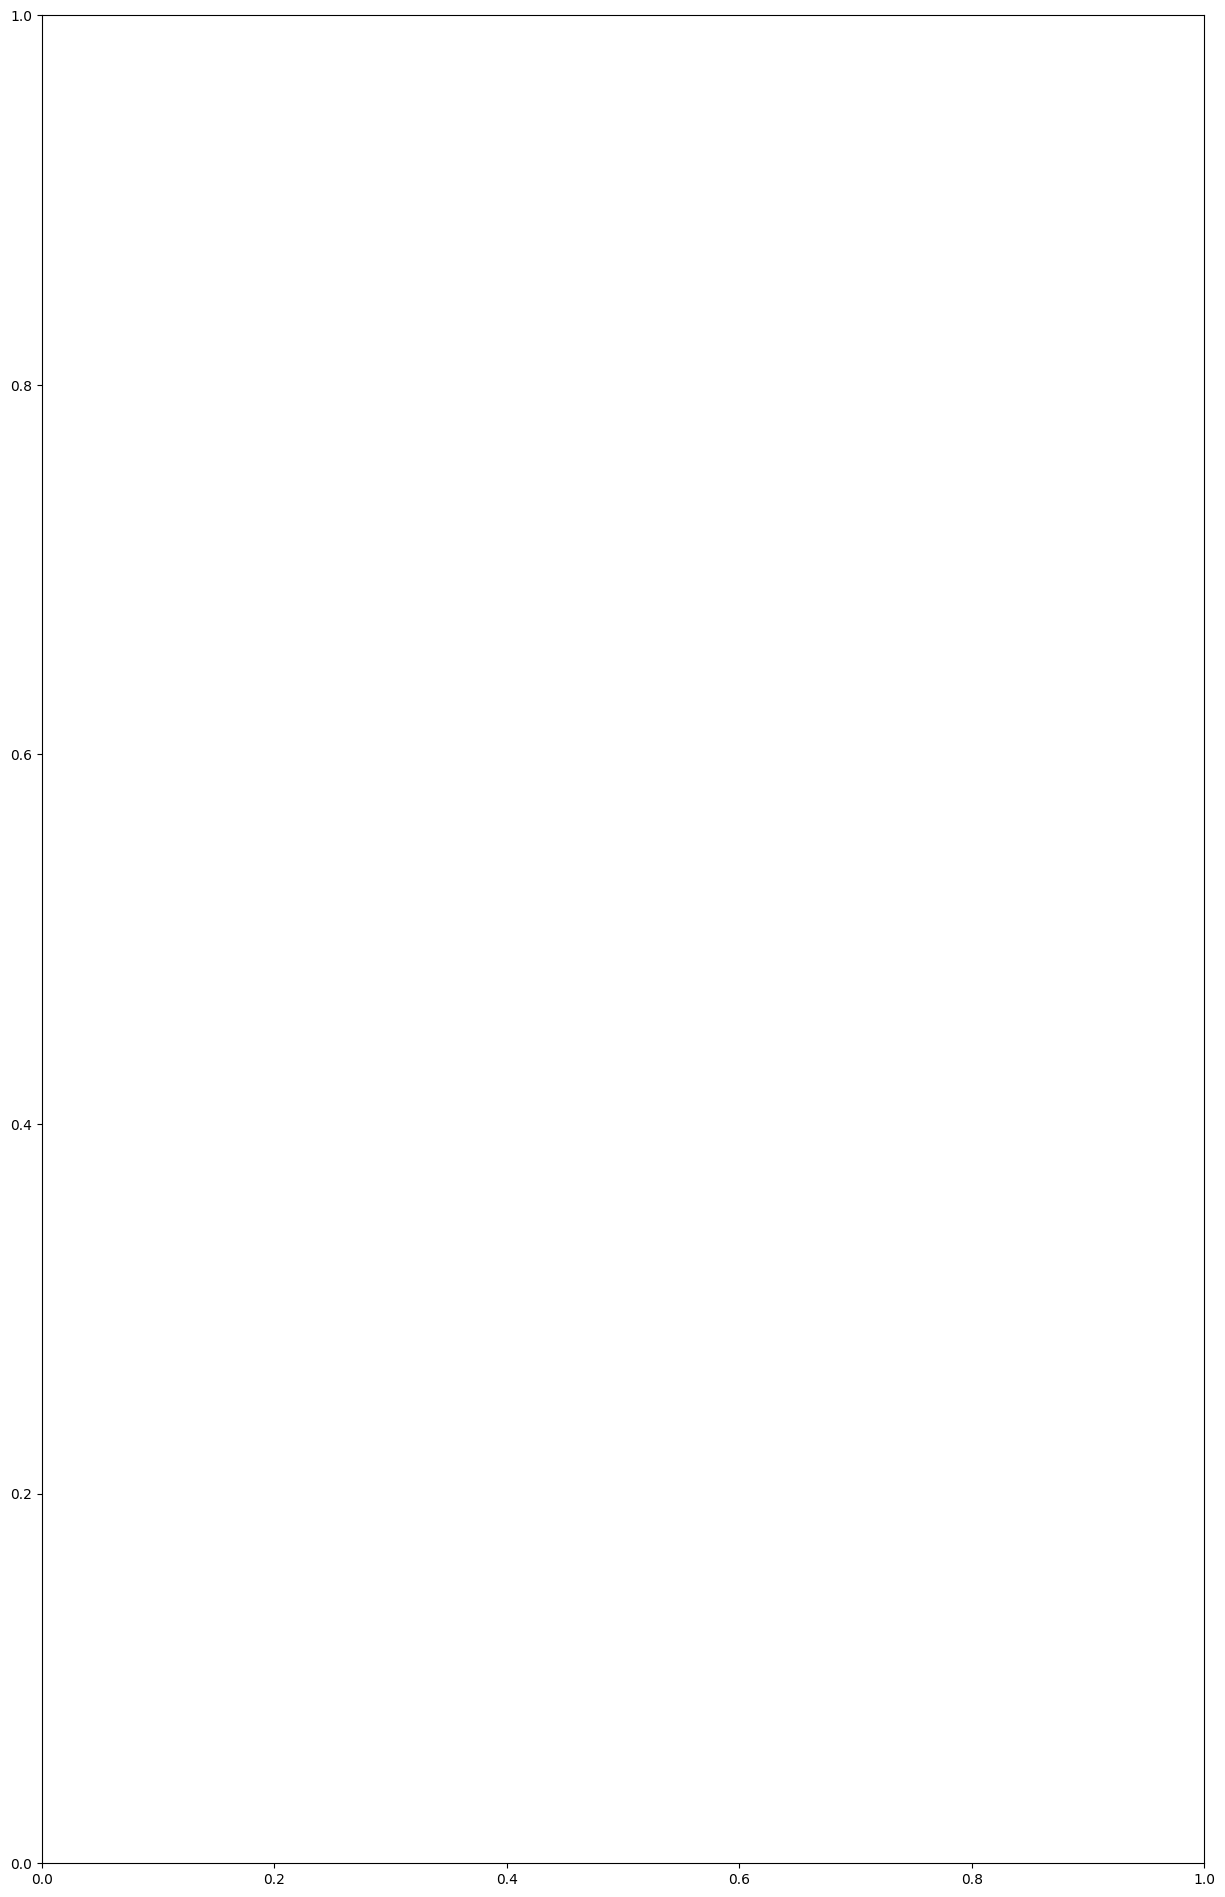

In [ ]:
for LME in LMES:
    my_range = []
    data_temp = []
    data_final=None

    #define figure
    LME_name=LME.replace(" - ", "_")
    LME_name=LME_name.replace(" ", "_")
    print(LME_name)
    fname=f'diff_scenario_ssp245_1979_1989_{LME_name}.csv'

    data_final = pd.read_csv(fname)
    fig, ax = plt.subplots(1, 1, figsize = (15, 24))
    print(np.unique(data_final['variable']))
    # ['no_ice', 'no_chl', 'no_wind', 'no_osa', 'no_meltpond', 'snow_sensitivity']
    #["no_ice", "no_chl", "no_wind", "no_osa", "no_meltpond", "snow_sensitivity"]
    #loop through the four removed settings (each loop will have an offset for the graph, the removed setting to subset the data, and a color for the graph)
    for i, var, col in zip([-0.3, -0.2, 0.0, 0.1, 0.2, 0.3], np.unique(data_final['variable']), ['tab:blue', 'tab:green', 'tab:red', 'tab:purple', 'tab:orange','tab:cyan','magenta']):
        #subset the data for only the removed variable
        data_temp = data_final[data_final['variable'] == var]
    
        if var not in ["minus_ice"]:
            #create a range based on the length of data and add the offset
            my_range=range(1,len(data_temp.index)+1)
            my_range = [j + i for j in my_range]

            #the horizontal plot is made using the hline function and the plot function
            ax.hlines(y=my_range, xmin=0, xmax=data_temp['diff'], color = col)
            ax.plot(data_temp['diff'], my_range, "o", color = col, label = var)

    #add titles and axis names
    ax.set_yticks(range(1, len(np.unique(data_final['model_combined'])) + 1), data_temp['model_combined'])
    #ax.set_xscale('log')
    fig.suptitle("Percent difference for model variables by changing light modules", horizontalalignment='left', x = 0.125, y = 0.93)
    #ax.set_title('Scenario SSP2-4.5', loc = 'left', fontsize = 10)
    ax.set_xlabel('Percent difference (%)')
    ax.set_ylabel('Variable')

    #add gridlines and legend
    ax.grid(linestyle = 'dotted', color = 'lightgrey', zorder = 0)
    L = ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), title = 'Removed Setting')

    #rename legend values
    #for i, label in enumerate(data_temp['model_combined']):
    #    print(label)
    #    L.get_texts()[i].set_text(label)

    # Show the plot
    ax.invert_yaxis()
    plt.savefig(f"Comparison_factors_affecting_par_month_{LME_name}.png", dpi=300, bbox_inches='tight')
  
    plt.show()

In [ ]:
data_final

,variable,diff,model_combined,model,member_id,factor
0,minus_ice,-90.763187,osa_CanESM5_r10i1p2f1,CanESM5,r10i1p2f1,osa
1,minus_snow_sens,0.000000,osa_CanESM5_r10i1p2f1,CanESM5,r10i1p2f1,osa
2,minus_meltpond,0.001112,osa_CanESM5_r10i1p2f1,CanESM5,r10i1p2f1,osa
3,minus_osa,0.244479,osa_CanESM5_r10i1p2f1,CanESM5,r10i1p2f1,osa
4,minus_chl,0.002607,osa_CanESM5_r10i1p2f1,CanESM5,r10i1p2f1,osa
...,...,...,...,...,...,...
283,minus_snow_sens,1.252846,uv_UKESM1-0-LL_r4i1p1f2,UKESM1-0-LL,r4i1p1f2,uv
284,minus_meltpond,-0.016299,uv_UKESM1-0-LL_r4i1p1f2,UKESM1-0-LL,r4i1p1f2,uv
285,minus_osa,-0.439096,uv_UKESM1-0-LL_r4i1p1f2,UKESM1-0-LL,r4i1p1f2,uv
286,minus_chl,-0.008945,uv_UKESM1-0-LL_r4i1p1f2,UKESM1-0-LL,r4i1p1f2,uv


## Heatmap


model             CanESM5  MPI-ESM1-2-HR  MPI-ESM1-2-LR  UKESM1-0-LL
variable                                                            
minus_chl        0.007974       0.029011       0.010833     0.026828
minus_meltpond  -0.003180      -0.000100      -0.000613    -0.013362
minus_osa       -0.403221      -0.418659      -0.420986    -0.427622
minus_snow_sens  0.595363       0.425144       0.402400     1.101715
minus_wind      -0.054316      -0.054478      -0.054322    -0.053439


/tmp/ipykernel_24380/1223357087.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_final['diff'] = data_final['diff'].astype(float)


Text(0.5, 1.0, 'Percent Difference For Model \nVariables by Removing Settings')

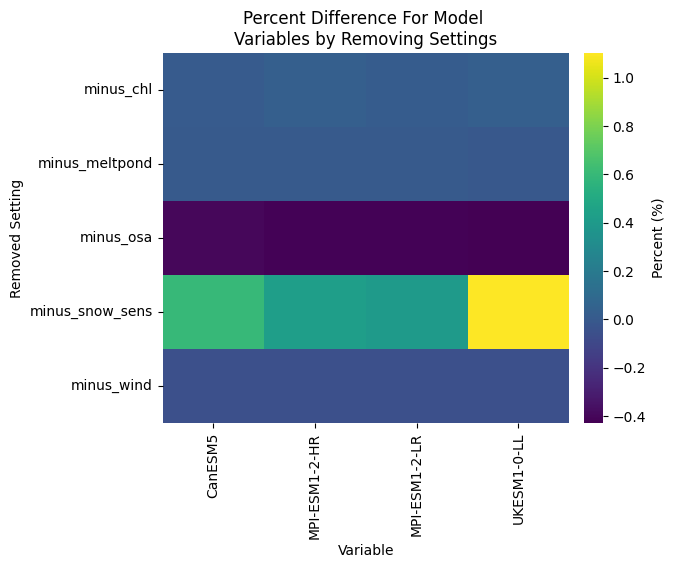

In [ ]:
y_axis_labels = ['minus_chl', 'minus_meltpond', 'minus_osa', 'minus_snow_sens', 'minus_wind'] # labels for y-axis

data_final = data_final[data_final["variable"]!="minus_ice"]

#convert the data to a float
data_final['diff'] = data_final['diff'].astype(float)
#convert the data from wide to long
data_final_filtered = data_final[data_final['model_combined'].str.contains('par_')]

data_heatmap = data_final_filtered.pivot_table(values='diff', index=['variable'], columns='model', aggfunc='mean')
sns.heatmap(data_heatmap, annot = False, cmap = 'viridis',
            cbar_kws={'pad': 0.03, 'label': 'Percent (%)'})

print(data_heatmap)


#add and format axis labels and title
plt.xlabel('Variable')
plt.ylabel('Removed Setting')
plt.yticks(rotation=0)
plt.title('Percent Difference For Model \nVariables by Removing Settings')
# plt.savefig('/Users/administrator/Downloads/Trond Data/Trond_SensitivityAnalysis_HeatMap.png', dpi = 300)

## Summarized Heatmap (Fit more Models)


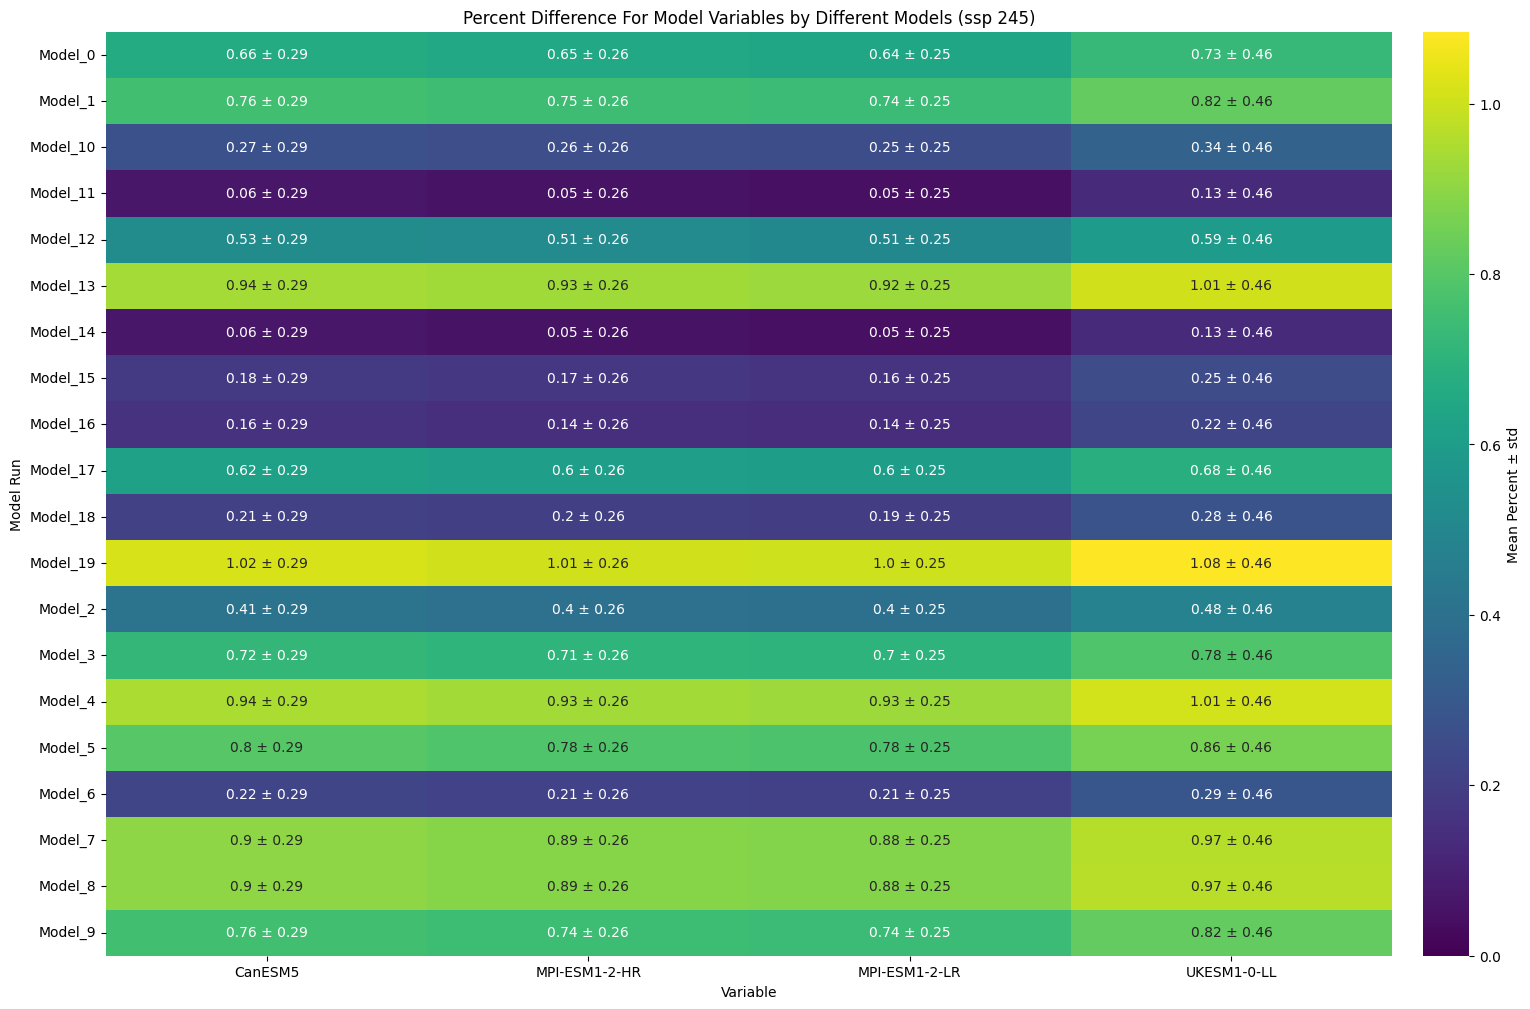

In [ ]:
#create some dummy data
data_full = pd.DataFrame()
for i in range(20):
    data_temp = data_final.copy()
    data_temp = data_temp.rename({'variable':'removed_setting'}, axis = 1)
    data_temp = data_temp.rename({'model':'variable'}, axis = 1)
    data_temp['diff'] = data_temp['diff'] + np.random.random()
    data_temp['model'] = 'Model_' + str(i)
    data_full = pd.concat([data_temp, data_full])
    
#summarize data by model run and variable
data_full = data_full.drop('removed_setting', axis = 1).groupby(['model', 'variable']).agg(['mean', 'std']).droplevel(0, axis=1).reset_index()

#custom y_axis_labels if you want them 
y_axis_labels= ['minus_chl', 'minus_ice', 'minus_meltpond', 'minus_osa', 'minus_snow_sens', 'minus_wind'] # labels for y-axis

#define axis labels 
data_full['labels'] = np.round(data_full['mean'], 2).astype(str) + ' ± ' + np.round(data_full['std'], 2).astype(str)
labels = data_full.pivot(index="model", columns="variable", values="labels").to_numpy()


plt.figure(figsize = (20, 12))
#convert data from wide to long
data_heatmap = data_full.drop('std', axis = 1).pivot(index="model", columns="variable", values="mean")
#visualize data in seaborn heatmap
sns.heatmap(data_heatmap, annot = labels, fmt = '', vmin = 0, cmap = 'viridis',
            cbar_kws={'pad': 0.02, 'label': 'Mean Percent ± std'}) #yticklabels=y_axis_labels)

#define axis labels and title
plt.xlabel('Variable')
plt.ylabel('Model Run')
plt.yticks(rotation=0)
plt.title('Percent Difference For Model Variables by Different Models (ssp 245)')
plt.savefig('Trond_SensitivityAnalysis_SummarizedHeatmap.png', dpi = 300)

## Taylor Diagram

Code modified from: https://stackoverflow.com/questions/67907069/label-taylor-diagram-with-number-by-python


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.projections import PolarAxes
import mpl_toolkits.axisartist.grid_finder as gf
import mpl_toolkits.axisartist.floating_axes as fa


class TaylorDiagram(object):
    def __init__(self, STD ,fig=None, rect=111, label='_'):
        self.STD = STD
        tr = PolarAxes.PolarTransform()
        # Correlation labels
        rlocs = np.concatenate(((np.arange(11.0) / 10.0), [0.95, 0.99]))
        tlocs = np.arccos(rlocs) # Conversion to polar angles
        gl1 = gf.FixedLocator(tlocs) # Positions
        tf1 = gf.DictFormatter(dict(zip(tlocs, map(str, rlocs))))
        # Standard deviation axis extent
        self.smin = 0
        self.smax = 1.6 * self.STD
        gh = fa.GridHelperCurveLinear(tr,extremes=(0,(np.pi/2),self.smin,self.smax),grid_locator1=gl1,tick_formatter1=tf1,)
        if fig is None:
            fig = plt.figure()
        ax = fa.FloatingSubplot(fig, rect, grid_helper=gh)
        fig.add_subplot(ax)
        # Angle axis
        ax.axis['top'].set_axis_direction('bottom')
        ax.axis['top'].label.set_text("Correlation coefficient")
        ax.axis['top'].toggle(ticklabels=True, label=True)
        ax.axis['top'].major_ticklabels.set_axis_direction('top')
        ax.axis['top'].label.set_axis_direction('top')
        # X axis
        ax.axis['left'].set_axis_direction('bottom')
        ax.axis['left'].label.set_text("Standard deviation")
        ax.axis['left'].toggle(ticklabels=True, label=True)
        ax.axis['left'].major_ticklabels.set_axis_direction('bottom')
        ax.axis['left'].label.set_axis_direction('bottom')
        # Y axis
        ax.axis['right'].set_axis_direction('top')
        ax.axis['right'].label.set_text("Standard deviation")
        ax.axis['right'].toggle(ticklabels=True, label=True)
        ax.axis['right'].major_ticklabels.set_axis_direction('left')
        ax.axis['right'].label.set_axis_direction('top')
        # Useless
        ax.axis['bottom'].set_visible(False)
        # Contours along standard deviations
        ax.grid()
        self._ax = ax # Graphical axes
        self.ax = ax.get_aux_axes(tr) # Polar coordinates
        # Add reference point and STD contour
        l , = self.ax.plot([0], self.STD, 'k*', ls='', ms=12, label=label)
        l1 , = self.ax.plot([0], self.STD, 'k*', ls='', ms=12, label=label)
        t = np.linspace(0, (np.pi / 2.0))
        t1 = np.linspace(0, (np.pi / 2.0))
        r = np.zeros_like(t) + self.STD
        r1 = np.zeros_like(t) + self.STD
        self.ax.plot(t, r, 'k--', label='_')
        # Collect sample points for latter use (e.g. legend)
        self.samplePoints = [l]
        self.samplePoints = [l1]
        
    def add_sample(self,STD,r,*args,**kwargs):
        l,= self.ax.plot(np.arccos(r), STD, *args, **kwargs) # (theta, radius)
        self.samplePoints.append(l)
        return l

    def add_sample(self,STD,r1,*args,**kwargs):
        l1,= self.ax.plot(np.arccos(r1), STD, *args, **kwargs) # (theta, radius)
        self.samplePoints.append(l1)
        return l1

    def add_contours(self,levels=5,**kwargs):
        rs, ts = np.meshgrid(np.linspace(self.smin, self.smax), np.linspace(0, (np.pi / 2.0)))
        RMSE=np.sqrt(np.power(self.STD, 2) + np.power(rs, 2) - (2.0 * self.STD * rs  *np.cos(ts)))
        contours = self.ax.contour(ts, rs, RMSE, levels, **kwargs)
        return contours

def srl(obsSTD, s, s1, r, r1, l, l1, m, m1, fname):
    fig=plt.figure(figsize=(8,8))
    dia=TaylorDiagram(obsSTD, fig=fig, rect=111, label='ref')
    plt.clabel(dia.add_contours(colors='#808080'), inline=1, fontsize=10)
    
    for mark, j, setting in zip(['o', '^', 's', 'h'], range(9), np.unique(m)):
        
        s = s_full.iloc[0+(j*4):4+(j*4)]
        r = r_full.iloc[0+(j*4):4+(j*4)]
        l = l_full.iloc[0+(j*4):4+(j*4)]
        m = m_full.iloc[0+(j*4):4+(j*4)]

        srlc = zip(s, r, l, m)
        srlc1 = zip(s1, r1, l1, m1)

        for i, col in zip(srlc, ['#e41a1c', '#377eb8', '#4daf4a', '#984ea3', '#ff7f00', '#ffff33', '#a65628', '#f781bf', '#999999']):
            dia.add_sample(i[0], i[1], label = i[2] + '-' + i[3], marker=mark, markersize = 10, mec = col, mfc = 'none', mew=1.6)

#     for i in srlc1:
#         dia.add_sample(i[0], i[1], label=i[2], marker='^', mec = 'blue', mfc = 'none', mew=1.6)
        
    spl = [p.get_label() for p in dia.samplePoints]
    fig.legend(dia.samplePoints, spl, numpoints=1, prop=dict(size='small'), loc=[0.82,0.5])
    fig.gca().set_aspect('equal')
    plt.show()

obsSTD = 6

# s = [1.275412605,1.391302157,1.424314937]
# s1 = [0.980035327,0.997244197, 1.003002031]
# r = [0.572272,0.533529,0.477572]
# r1 = [0.82,0.72,0.8]

# l = ['A', 'B', 'C']
# l1 = ['A', 'B', 'C']

s_full = data_final['Std']
r_full = data_final['Corr']
l_full = data_final['Variable']
m_full = data_final['Setting']

fname = 'TaylorDiagram.jpg'
srl(obsSTD, s_full, s1, r_full, r1, l_full, l1, m_full, m1, fname)

KeyError: 'Std'

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Define the function to be plotted
def ice_thickness_function(ice_thickness, fhtan):
    return np.where((np.arctan(ice_thickness * 4.0) / fhtan) >= 1.0, 1.0, np.arctan(ice_thickness * 4.0) / fhtan)
ahmax = 0.5

# Calculate fhtan
fhtan = np.arctan(ahmax * 4.0)

# Generate 1000 points between 0 and 1 for ice_thickness
ice_thickness_values = np.linspace(0, 1, 1000)

# Compute the function values
function_values = ice_thickness_function(ice_thickness_values, fhtan)

# Plot using Seaborn
sns.set()  # Apply the default Seaborn theme, scaling, and color palette
plt.figure(figsize=(10, 6))  # Set the figure size
sns.lineplot(x=ice_thickness_values, y=function_values)  # Create the line plot
plt.title('Plot of the ice_thickness function')  # Set the title of the plot
plt.xlabel('Ice Thickness')  # Set the x-axis label
plt.ylabel('Function Value')  # Set the y-axis label
plt.show()  # Display the plot
